In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
import os 
import datetime as dt
import statsmodels as sm
import math
from statistics import mean 

In [2]:
#Importing evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
#setting working directory
os.chdir("C:/Users/mah/Desktop/M5_Wallmart_Challenge")
os.getcwd()

'C:\\Users\\mah\\Desktop\\M5_Wallmart_Challenge'

In [4]:
#reading in the revenue_CA_1_FOODS_day time series csv
revenue_CA_1_FOODS_day = pd.read_csv("revenue_CA_1_FOODS_day.csv", index_col='date')
#setting the index which was saved as a row back as the index

In [5]:
#defining the training and evaluation set
#training data
y = revenue_CA_1_FOODS_day[:-365]
#evaluation(prediction) data
y_predict = revenue_CA_1_FOODS_day[-365:]

In [6]:
#reading in the exogen variables which are the SNAP, Sporting, Cultural, National and Religious events
exogen = pd.read_csv("exogen_variables.csv", index_col='date')

In [7]:
#Define training and prediction data sets for the exogen variables
exog_to_train = exogen.iloc[:(len(revenue_CA_1_FOODS_day)-365)]
exog_to_test = exogen.iloc[(len(revenue_CA_1_FOODS_day)-365):]

In [8]:
'''
Initialization according to Hyndman et al. 2008 p.23

1.Initial seasonal Component
  computing a 2xm  moving average: this means computing a m times moving average followed by a 2 times moving average.
  Explained in Forecastin Principles: https://otexts.com/fpp2/moving-averages.html (Moving averages of Moving averages)
  The 2xm moving average is computed for the first year of the data: y[:371].
'''
f = y[:371].rolling(window=7).mean()
f = f.rolling(window=2).mean()
d = y[7:371]/f[7:]

In [9]:
#making the Index of d to a datetime variable
d.index = pd.to_datetime(d.index, format='%Y-%m-%d')

In [100]:
#Check what weekday the first observation is: Day 5 --> Saturday (Monday is =0)
y.index = pd.to_datetime(y.index, format='%Y-%m-%d')

y.index[0].weekday()

5

In [11]:
#grouping d by the day of the week and computing the means
s_inits = d.groupby(d.index.dayofweek).mean()

In [12]:
#Define all inital seasonal values
#Note:The oldes value is the current seasonal
s_init7 = s_inits.at[5, 'revenue']
s_init6 = s_inits.at[4, 'revenue']
s_init5 = s_inits.at[3, 'revenue']
s_init4 = s_inits.at[2, 'revenue']
s_init3 = s_inits.at[1, 'revenue']
s_init2 = s_inits.at[0, 'revenue']
s_init  = s_inits.at[6, 'revenue']

In [13]:
#Normalizing the seasonal indices so they add to m
#done by dividing them all by there total sum and multiplying with m (m=7)
total = s_init7 + s_init6 + s_init5 + s_init4 + s_init3 + s_init2 + s_init

multiplier = 7 / total

s_init7 = s_init7 * multiplier
s_init6 = s_init6 * multiplier
s_init5 = s_init5 * multiplier
s_init4 = s_init4 * multiplier
s_init3 = s_init3 * multiplier
s_init2 = s_init2 * multiplier
s_init  = s_init * multiplier

In [14]:
'''
Initial Level and slope components
Hyndman 2008 p.23-24

Basically it is a Linear regression of time on the first 10 seasonally adusted values.
The coefficient of this Linear regression becomes the trend starting parameter.
The Intercept of the linear regression becomes the level starting parameter.
'''
#creating a dataframe containing the first 10 values seasonaly adjusted (values) and a time index (t)
first_10 = pd.DataFrame()
first_10['values'] = np.zeros(10)
first_10['t'] = range(0,10)
#computing the seasonal adjustment
#first creating a data frame with the first 10 seasonal adjustments
s_intit_all = s_init7,s_init6,s_init5,s_init4,s_init3,s_init2,s_init,s_init7,s_init6,s_init5
s_intit_all = pd.DataFrame(s_intit_all, columns=['inits'])
#computing the seasonally adjusted values
for i in range(0,10):
    first_10.at[i,'values'] = y['revenue'][i] / s_intit_all.at[i,'inits']

In [15]:
#Computing the Linear regression
from sklearn.linear_model import LinearRegression
#computing a regression of time on the first 10 seasonally adjusted values
reg = LinearRegression().fit(first_10['t'].values.reshape(-1,1),first_10['values'].values.reshape(-1,1))

In [16]:
#Intial slope component is equal to the regression coefficient
#Note: the two zeros in squared brackets take out the pure scalar value out of the array result
b_init = reg.coef_[0][0]

In [17]:
#Initial level component is equal to the intercept
#Note: same reason for the zero as above
l_init = reg.intercept_[0]

In [18]:
'''
Initial values for the regressors
These are obtained by regressing them onto the entire data set.
Note that there is no explicit method mentioned in Hyndman et al 2008.
This method is simply the most intuitive one.
I use the entire training data as some events only happen once a year.
Note that I use y adjusted for its weekly seasonality effect estiamted above.
The regression coefficients are divided by the mean of the training data as
in the model I include multiplicative/relative dummy variables.
'''

#defining weekly transition matrix: (as below in seasonal definition function)
col_1 = np.vstack(np.zeros(6))
col_2_6 = np.identity(6)
matrix_6 = np.hstack((col_1,col_2_6))
row_7 = np.concatenate((1,np.zeros(6)), axis = None)
weekly_transition_matrix = np.vstack((matrix_6,row_7))

#creating vertikal vector of the 7 weekly adjustment coefficients
s_inits = np.vstack(np.concatenate(s_intit_all.loc[0:6,'inits'],axis=None))

y_weekly_adj = list()

#creating a list of y values which are divided by there weekly seasonality, thus multiplicativ weekly effect is taken out
for i in range(0,len(y)):
    y_weekly_adj.append(y['revenue'][i] / s_inits[0])
    s_inits = np.dot(weekly_transition_matrix,s_inits)


reg2 = LinearRegression().fit(exog_to_train,y_weekly_adj)

In [19]:
#defining values for starting parameters
#as we have a model with multiplicative effect i divide the coefficients by the mean over the time period
Snap_reg = reg2.coef_[0][0] / mean(y['revenue'])
Sporting_reg = reg2.coef_[0][1] / mean(y['revenue'])
Cultural_reg = reg2.coef_[0][2] / mean(y['revenue'])
National_reg = reg2.coef_[0][3] / mean(y['revenue'])
Religious_reg = reg2.coef_[0][4] / mean(y['revenue'])

In [20]:
yearly = pd.DataFrame({'date': exog_to_train.index})
yearly['date'] = pd.to_datetime(yearly['date'])
yearly = yearly.set_index(yearly['date'])

In [21]:
'''
Initial parameters for yearly seasonality modelled by a fourier series
Starting Parameters are estimated by linear regression.
Note that we controll for the weekly seasonality by day dummies and for the events by including the exog df into the regression.
Als we have evnt tyes we can regres on only the first year since each event type happens multiple times
If however we choose to put in each event individually in the future we need to regress over multiple years as for example
thnakgiving is only one a year.

Building a Data Frame with the values for each time point of each series part for the fit data set

N=The number of Sinus and Cosinus Terms that are included
P=Cycle length, defined as 
                            365 for yearly seasonality (not 365.25 due to leap years becuase for the leap year 29th feb 
                            we assume the same value as for the 28th feb of every year: see if else condition) 
t=time index is defined as 
                            the day of the year (0-365) for yearly seasonality
'''


#yearly seasonality with N=10
#N=1
yearly['yearly_sin365'] = np.sin(2 * np.pi * yearly.index.dayofyear / 365)
yearly['yearly_cos365'] = np.cos(2 * np.pi * yearly.index.dayofyear / 365)
#N=2
yearly['yearly_sin365_2'] = np.sin(4 * np.pi * yearly.index.dayofyear / 365)
yearly['yearly_cos365_2'] = np.cos(4 * np.pi * yearly.index.dayofyear / 365)
#N=3
yearly['yearly_sin365_3'] = np.sin(6 * np.pi * yearly.index.dayofyear / 365)
yearly['yearly_cos365_3'] = np.cos(6 * np.pi * yearly.index.dayofyear / 365)
#N=4
yearly['yearly_sin365_4'] = np.sin(8 * np.pi * yearly.index.dayofyear / 365)
yearly['yearly_cos365_4'] = np.cos(8 * np.pi * yearly.index.dayofyear / 365)
#N=5
yearly['yearly_sin365_5'] = np.sin(10 * np.pi * yearly.index.dayofyear / 365)
yearly['yearly_cos365_5'] = np.cos(10 * np.pi * yearly.index.dayofyear / 365)
#N=6
yearly['yearly_sin365_6'] = np.sin(12 * np.pi * yearly.index.dayofyear / 365)
yearly['yearly_cos365_6'] = np.cos(12 * np.pi * yearly.index.dayofyear / 365)
#N=7
yearly['yearly_sin365_7'] = np.sin(14 * np.pi * yearly.index.dayofyear / 365)
yearly['yearly_cos365_7'] = np.cos(14 * np.pi * yearly.index.dayofyear / 365)
#N=8
yearly['yearly_sin365_8'] = np.sin(16 * np.pi * yearly.index.dayofyear / 365)
yearly['yearly_cos365_8'] = np.cos(16 * np.pi * yearly.index.dayofyear / 365)
#N=9
yearly['yearly_sin365_9'] = np.sin(18 * np.pi * yearly.index.dayofyear / 365)
yearly['yearly_cos365_9'] = np.cos(18 * np.pi * yearly.index.dayofyear / 365)
#N=10
yearly['yearly_sin365_10'] = np.sin(20 * np.pi * yearly.index.dayofyear / 365)
yearly['yearly_cos365_10'] = np.cos(20 * np.pi * yearly.index.dayofyear / 365)

#deleting date column as it is no longer required and should not be in the linear regression
del yearly['date']

In [22]:
#add week day dummies so that weekly seasonality is accounted for
yearly['Monday'] = np.zeros(len(yearly))
for i in range(0,len(yearly)):
    if yearly.index.dayofweek[i] == 0:
        yearly['Monday'][i] = 1
    else:
        yearly['Monday'][i] = 0
        
yearly['Tuesday'] = np.zeros(len(yearly))
for i in range(0,len(yearly)):
    if yearly.index.dayofweek[i] == 1:
        yearly['Tuesday'][i] = 1
    else:
        yearly['Tuesday'][i] = 0
        
yearly['Wensday'] = np.zeros(len(yearly))
for i in range(0,len(yearly)):
    if yearly.index.dayofweek[i] == 2:
        yearly['Wensday'][i] = 1
    else:
        yearly['Wensday'][i] = 0
        
yearly['Thursday'] = np.zeros(len(yearly))
for i in range(0,len(yearly)):
    if yearly.index.dayofweek[i] == 3:
        yearly['Thursday'][i] = 1
    else:
        yearly['Thursday'][i] = 0
        
yearly['Friday'] = np.zeros(len(yearly))
for i in range(0,len(yearly)):
    if yearly.index.dayofweek[i] == 4:
        yearly['Friday'][i] = 1
    else:
        yearly['Friday'][i] = 0
        
yearly['Saturday'] = np.zeros(len(yearly))
for i in range(0,len(yearly)):
    if yearly.index.dayofweek[i] == 5:
        yearly['Saturday'][i] = 1
    else:
        yearly['Saturday'][i] = 0
        
yearly['Sunday'] = np.zeros(len(yearly))
for i in range(0,len(yearly)):
    if yearly.index.dayofweek[i] == 6:
        yearly['Sunday'][i] = 1
    else:
        yearly['Sunday'][i] = 0
        

In [23]:
#Further add events so they are also accounted for and do not distort the seasonality
#pd.merge(yearly,exog_to_train, left_index=True, right_index=True) #axis=1 should mean that column are simply added
yearly = pd.merge(yearly[0:365], exog_to_train[0:365], left_index=True, right_index=True)

In [24]:
#Linear regression
#we regress the 20 sin(t) and cos(t) from our fourier series + 7 weekly dummies (as control) on the entire 1 year fit data
#this gets us estimates for the fourier series weights in the first year
reg3 = LinearRegression().fit(yearly,y[0:365])

In [25]:
#deviding the resulting coefficients by the mean of the data over that period
#reason: we have multiplicative thus relative seasonality, in our regression we have absolute 
#so we divide by series mean to get relative estiamtes
yearly_init = reg3.coef_ / mean(y['revenue'])

In [26]:
#we ommit our 7 daily seasonality estimates so that we only have the yearly estimates for the optimization
#minus 12 is for the 7 weekdays + the 5 eventtyps
yearly_init = yearly_init[0][:-12]

In [27]:
#defining DataFrame of fourier Series Sin(t) and Cos(t) components as vektor with whom to calculate the daily values in Model
#will simply be inputed into the model as argument
Fourier = yearly.iloc[0:365,0:-12]

In [123]:
def model(params, y, exog, Fourier, date):

    '''
    1.This function runs an ETS(M,Ad,M) model with exogen variables and double seasonality. This is an Error, Trend, 
      Seasonality exponential smoothing model. We have weekly and yearly seasonality. 
      The first M stands for multiplicativ or relativ errors, the Ad for an additiv dampend trend and the last M for 
      multiplikativ seasonality. Weekly seasonality is modelled 
      by expoentially smoothed dummies and yearly seasonality is modelled by a 10 terms (10xsin and 10xcos) fourier series 
      which is also exponetially smoothed. The Fourier series creates initial dummies which are smoothed.
      The definition by the fourier series allows to lower the number of parameters to estimate: I dont estimate 365 dummies 
      but rather 20 furier series weights and compute the dummies with them.
      The model also contains additional exogen variables which are dummies for certain events.
      The actual computation of the fit model is done in the function ETS_M_Ad_M which further contains the functions 
      calc_new_estimates, calc_error, save_estimates and seasonal_matrices. These are all explained in the following code.
    
    2.The Inputs are for an array of model parameters (param), the time series to fit (y) and the exogen variables (exog).
      Params includes the smoothing factors and starting values for the level, trend and seasonality.
      
      Time independent smoothing parameters:
      alpha = level smoothing coefficient
      beta = trend smoothing coefficient
      gamma = seasonality smoothing coefficient
      omega = trend dampening coefficient
      
      Initial states computed above according to Hyndman 2008.
      l_init_HM = initial level
      b_init_HM = initial trend
      s_init7_HM ... s_init_HM = initial seasonal component where the number determines the lag of the dummy
      
      The exogen variables are equal to one on days of their repective events otherwise zero :
      SNAP = Days where the Food assistance Programm of The Goverment hands out money for poorer people to by groceries
      Sporting = Events like the super bowl
      Cultural = Events like Thanksgiving
      National = Events like the fourth of July (Independence Day)
      Religious = Events like Ramadan or Chistmas
      
      20 Fourier series weights = 1 per sin(t) and cos(t) function
      epsilon = yearly seasonality smoothing coefficient
      
      Fourier = 
      Date = contains the dates, the index, of y. It is used later on to control for leap year effect on yearly seasonality
      
    
    3.The function returns the sum of squared error of the fitted model. This allows the model to be inputed 
      into an optimizer which minimizes the sum of squared residuals dependent on the input parameters (param). 
      Following Hyndman 2008 p.69 the Adjusted Least Squared (ALS) estimate is equal to the ML estimate 
      in the case of homoskedastic errors. As we incorperate the heteroskedasticity of the series threw 
      multiplicativ components this assumption is valid.
    '''
    
    alpha = params[0]
    beta = params[1]
    gamma = params[2]
    omega = params[3]
    l_init_HM = params[4]
    b_init_HM = params[5]
    
    
    #creating a vertical vector of weekly seasonality dummies
    s_init_HM = np.vstack(params[6:13])
    
    #creating a vector for the regression coefficients
    reg = (params[13:18])
    
    #defining the initial yearly seasonal components
    #1. compute the fourier series results from the weights times the cos(t) and sin(t) for t=0...365
    yearly_init = params[18:38] * Fourier
    #2. sum up the total yearly seasonality of each day by summing up all weighted trigonometric functional values
    yearly_init = 1 + yearly_init.sum(axis=1)
    #3. define this array of 365 dummies as an array
    yearly_init = np.vstack(yearly_init)
    #4. turn the array around as we want the most recent seasonality effect to be at the end
    yearly_init = yearly_init[::-1]
    
    #yearly smoothing parameter
    epsilon = params[38]
        
        
    #printing the parameter estimates in each optimization step
    print('alpha:', alpha,'beta:', beta,'gamma:', gamma, 'omega:', omega,
          l_init_HM,b_init_HM,s_init_HM,
         'reg:', ([params[13],params[14],params[15],params[16],params[17]]),
         'Fourier weights:', params[18:38],
         'epsilon:', params[38])

    
    results = ETS_M_Ad_M(alpha,beta,gamma,omega,
          l_init_HM,b_init_HM,s_init_HM,yearly_init,epsilon,reg,y,exog,date)
    
    error_list = results['errors_list']
    
    error_list = [number ** 2 for number in error_list]
    
    #returning the sum of squared errors
    #this is the ML estimate, or rather Adjusted Least Squared (ALS)
    #Hyndman p. 69
    error_sum = sum(error_list)
    
    #Prints the current so that during the optimization it becomes visible if the algorythm makes progress
    print(error_sum)
   
    return error_sum

    


In [115]:
def calc_new_estimates(l_past, b_past, s_past, alpha, beta, omega, gamma, e, 
                                          weekly_transition_matrix, weekly_update_vector,
                       yearly_transition_matrix, yearly_past, yearly_update_vector,leap_year_update_vector, epsilon,date,i):
    
    """
    1.This function updates the state estimates of the ETS(M,Ad,M) model l_past, b_past, s_past by the innovations/errors
      of each period. It is a part of the loop of the fit calculator of the model. Note that it also moves up the dummies
      in the seasonality vector. Further it includes an exception printing all parameters for the case that computation issues
      arise. This helps to identify possible issues and was suggested by Lucca Furrer.
      Note that the inclusion of yearly seasonality means updating the yearly dummy state vector needs to be updated.
      A big Issue are leap years which have 366 Days and thus distort the yearly 365 vector. This is solved by 
      assuming the 29th febuary, the leap year extra day, to have the same yearly pattern as the 28th febuary.
      In terms of conditions: if it is a leap year, febuary and one day before the end of the month it is the 28th febuary
      of a leap year. then we update the state but do not transition the vector so that the upper value goes down and all
      values move up one position. The else condition holds the normal case of updating. The special leap_year_update_vector 
      is defined in the seasonal definition function. For this reason we import the date and the time point i.
    
    2.The Inputs are all past states, the smoothing parameters and the weekly_transition_matrix and weekly_update_vector
      required to update the current dummy, put it at the bottom of the vector and move the dummies up one position each period.
      
      Past state estimates:
      l_past = past level
      b_past = past trend
      s_past = past weekly seasonality dummy vector
      yearly_past = past yearly seasonality dummy vector
      
      Time independent smoothing parameters:
      alpha = level smoothing coefficient
      beta = trend smoothing coefficient
      gamma = seasonality smoothing coefficient
      omega = trend dampening coefficient
      
      constant matrix and vector for the seasonality:
      weekly_transition_matrix = serves the purpose of pushing all dummies up one position 
                                 while the current dummy goes to the bottom
      weekly_update_vector = is zero for all parameters except the current dummy in last position, which is updated by e.
      yearly_transition_matrix = serves the purpose of pushing all dummies up one position 
                                 while the current dummy goes to the bottom
      yearly_update_vector = is zero for all parameters except the current dummy in last position, which is updated by e.
      leap_year_update_vector = is zero for all parameters except the current dummy in first position, which is updated by e.
      
      date = date index of the time series y
      i = time point
    
    3.The function returns the updated states.
      l = updated level
      b = updated trend
      s = updated seasonality vector
    
    """
    
    
    try:
        #updating all state estimates for time point t
        l = (l_past + omega * b_past) * (1 + alpha * e)
        b = omega * b_past + beta * (l_past + omega * b_past) * e
        #s = s_past * (1 + gamma * e)
        #updating the weekly dummy state vector
        
        s = np.dot(weekly_transition_matrix,s_past) + weekly_update_vector * gamma * e
        
        if(date.is_leap_year[i] == True) and (date.month[i] == 2) and (date.is_month_end[i+1] == True):
            yearly = yearly_past + leap_year_update_vector * epsilon * e
        else:
            yearly = np.dot(yearly_transition_matrix,yearly_past) + yearly_update_vector * epsilon * e
        
    except:
        print('lpast: ',l_past) 
        print('bpast', b_past) 
        print('spast', s_past) 
        print('alpha', alpha) 
        print('beta', beta) 
        print('omeag', omega) 
        print('gamma', gamma) 
        print('error', e)
        print('yearly_past', yearly_past[0])
        print('yearly_transition_matrix', yearly_transition_matrix[0])
        print('yearly_update_vector', yearly_update_vector[0])
        print('epsilon', epsilon)
        print('y[i]', y[i])
        print('y.index[i]', y.index[i])
        print('y.index.is_leap_year[i]', y.index.is_leap_year[i])
        print('y.index.month[i]', y.index.month[i])
        print('y.index.is_month_end[i+1]', y.index.is_month_end[i+1])

    
    return l,b,s,yearly


In [116]:
def calc_error(l_past, b_past, s_past, omega, y, i, reg, exog, yearly_past):
     
        """
    1.This function calculates the point forecast, the relativ and absolute forecasting error of the ETS(M,Ad,M) model.
      It is a part of the loop of the fit calculator of the model and thus time i dependent. The absolute errors are computed
      for the sum of squared errors. Note that the sum of squared errors could also be computed with the relativ errors.
      Here the exogen variables are included. In the computation of the forecast a term is added where the regressors are multiplied
      by their coefficients and the estiamte purely basted n the ETS Model. This allows us to have multiplicative effects of events
      without running into the issue of having an estimate of zero on days without events. Note that we have two seasonality 
      dummies multiplied: the weekly and yearly dummies.
    
    2.The Inputs are all past states and the trend dampening factor, the time point i, the time series to estimate y as well as  the
      exogen variables and their regressors.
      
      Past state estimates:
      l_past = past level
      b_past = past trend
      s_past = past weekly seasonality dummy vector
      yearly_past = past yearly seasonality dummy vector
      
      Time independent smoothing parameters:
      omega = trend dampening coefficient
      
      time dependent:
      y = time series
      i = time
      
      regression:
      exog = exogen variables (time dependent)
      reg = regression coefficient vector
      
    
    3.The function returns the point forecast, the relativ and absolute error.
      mu = point forecast
      e = relativ error
      e_absolute = absolute error
    
    """
        
        mu = (l_past + omega * b_past) * s_past[0] * yearly_past[0] + np.dot(reg,exog.iloc[i]) * (l_past + omega * b_past) * s_past[0]  * yearly_past[0]

        e = (y[i] - mu) / y[i]
      
        e_absolute = y[i] - mu

        return mu, e, e_absolute

In [117]:
def save_estimates(errors_list,point_forecast,l_list,b_list,s_list,e_absolute,mu,l_past,b_past,s_past,yearly_past):
    
    """
    1.This function simply appends the state estimates, the point forecast and the absolute error of each period 
      to previously defined lists in the ETS(M,Ad,M) model. It is a part of the loop of the fit calculator of the model.
      The Function has no difference to the model without exogen variables.
    
    2.The Inputs are all past states, the point forecast, the absolute error and their respective lists
      
      Past state estimates:
      l_past = past level
      b_past = past trend
      s_past = past weekly seasonality dummy vector
      yearly_past = past yearly seasonality dummy vector
      
      mu = point forecast
      e_absolute = absolute error
      
      Lists accoridng to the above variables:
      errors_list
      point_forecast
      l_list
      b_list
      s_list
    
    3.The function returns the updated Lists.
      errors_list
      point_forecast
      l_list
      b_list
      s_list
      yearly_list
    
    """
    
    errors_list.append(e_absolute) 
    point_forecast.append(mu)
    l_list.append(l_past)
    b_list.append(b_past)
    s_list.append(s_past[0])
    yearly_list.append(yearly_past[0])
    
    return errors_list,point_forecast,l_list,b_list,s_list,yearly_list


In [118]:
def seasonal_matrices():
    
    '''
    1. This function simply defines the weekly transition matrix and weekly updating matrix needed i nthe computation of
       new weekly seasonality dummies. The function is part of the fit function allthough it is part of the initialisation
       and merly used in the loop as new state estimates are computed.
       The Function has no difference to the model without exogen variables.
       
    2. It has no inputs allthough it can be made more general at which point it would include a scalar as input containg the 
       length of the seasonality. Here it is 7
       
    3. It returns the above weekly transition matrix and the weekly updating matrix.
       weekly_transition_matrix
       weekly_update_vector
    
    '''
    
    #defining yearly transition matrix:
    #1. defining first column of zeros (1 row to short)
    col_1 = np.vstack(np.zeros(364))
    #2. defining identity matrix 1 row and column to small
    col_2_365 = np.identity(364)
    #3. adding the 1 column and the identity matrix, now all states are updated to jump up one step in the state vector
    matrix_364 = np.hstack((col_1,col_2_365))
    #4. creating a final row in which the current state is put in last place and will be added by an update
    row_365 = np.concatenate((1,np.zeros(364)), axis = None)
    #5. adding the last row to the matrix to make it complete
    yearly_transition_matrix = np.vstack((matrix_364,row_365))
    
    #defining weekly transition matrix:
    #1. defining first column of zeros (1 row to short)
    col_1 = np.vstack(np.zeros(6))
    #2. defining identity matrix 1 row and column to small
    col_2_6 = np.identity(6)
    #3. adding the 1 column and the identity matrix, now all states are updated to jump up one step in the state vector
    matrix_6 = np.hstack((col_1,col_2_6))
    #4. creating a final row in which the current state is put in last place and will be added by an update
    row_7 = np.concatenate((1,np.zeros(6)), axis = None)
    #5. adding the last row to the matrix to make it complete
    weekly_transition_matrix = np.vstack((matrix_6,row_7))
    
    
    #defining the yearly updating vector
    yearly_update_vector = np.vstack(np.concatenate((np.zeros(364),1), axis = None))
    
    #defining leap year updating vector
    leap_year_update_vector = np.vstack(np.concatenate((1,np.zeros(364)), axis = None))
    
    #defining the weekly updating vector
    weekly_update_vector = np.vstack(np.concatenate((np.zeros(6),1), axis = None))
    
    
    return yearly_transition_matrix, weekly_transition_matrix, yearly_update_vector, leap_year_update_vector, weekly_update_vector

In [119]:
#This script defines an ETS(M,Ad,M) Model
#Exponential Smoothing Model with multiplicativ errors, and additive dampened trend and multiplicativ seasonality

#Formulas from Hyndman et al. 2008 p.22
#mu = prediction(t)
#l = level(t)
#b = trend(t)
#s = seasonality(t)
#e = prediction error(t)
#omega = trend dampening coefficient
#alpha = level smoothing coefficient
#beta = trend smoothing coefficient
#gamma = seasonality smoothing coefficient
def ETS_M_Ad_M(alpha,beta,gamma,omega,
          l_init_HM,b_init_HM,s_init_HM, 
               yearly_init,epsilon,reg,y,exog,date):
    
    #computing the number of time points as the length of the forecasting vector
    t = len(y)
    errors_list = list()
    point_forecast = list()
    l_list = list()
    b_list = list()
    s_list = list()
    yearly_list = list()
    
    
    yearly_transition_matrix, weekly_transition_matrix, yearly_update_vector, leap_year_update_vector, weekly_update_vector = seasonal_matrices()
    #Note: can create a seasonal matrix funciton which creates the transition matrix and update vector
    #depending on the length of seasonality
    #then i need to call the function twice, once for each seasonal length
    #would give the code more generalisation


    #Initilaisation
    l_past = l_init_HM
    b_past = b_init_HM
    
    yearly_past = yearly_init
    
    s_past = s_init_HM


    #computation loop:
    for i in range(0,t): #start at 1 as the first index '0' is used in the initialization
        #Prediciton
        

        #Observation
        #compute one step ahead  forecast for timepoint t
        mu, e, e_absolute = calc_error(l_past, b_past, s_past, omega, y, i, reg, exog, yearly_past)

        #save estimation error for Likelihood computation
        #saving squared errors
        errors_list,point_forecast,l_list,b_list,s_list,yearly_list = save_estimates(errors_list,point_forecast,l_list,b_list,s_list,
                                                                         e_absolute,mu,l_past,b_past,s_past,yearly_past)
    

        #Updating
        #updating all state estimates for time point t
        l,b,s,yearly = calc_new_estimates(l_past, b_past, s_past, alpha, beta, omega, gamma, e, 
                                          weekly_transition_matrix, weekly_update_vector,
                       yearly_transition_matrix, yearly_past, yearly_update_vector,leap_year_update_vector, epsilon,date,i)
        
        
       
        #denote updated states from t-1 as past states for time point t
        l_past = l
        b_past = b
        #Special case for seasonality as the past observation is exactly one cycle length i nthe past
        #Here weekly seasonality thus 7 days
        #We first define the past seasonality as the seasonality seven days ago
        s_past = s
        
        yearly_past = yearly

    return  {'errors_list' : errors_list, 'point forecast' : point_forecast,
             'l_list' : l_list, 'b_list' : b_list, 's_list' : s_list, 'yearly_list' : yearly_list}




In [130]:
#Defining Starting Parameters
#Note: I put them parameters in a Dataframe because latter on i input them in the model function with the .at[..,..] command 
Starting_Parameters = np.concatenate((0.1, #alpha
                       0.01, #beta
                       0.01, #gamma
                       0.99, #omega --> all starting values according to Hyndman 2008 p.24
                       l_init,
                       b_init,
                       s_init7,
                       s_init6,
                       s_init5,
                       s_init4,
                       s_init3,
                       s_init2,
                       s_init,
                      Snap_reg, 
                      Sporting_reg,
                      Cultural_reg,
                      National_reg,
                      Religious_reg,
                      yearly_init,
                      0.01), axis=None) #assuming epsilon, the smoothing parameters of the yearly seasonality to me small, thus to assume 
#that the yearly multiplicative seasonality stays relatively constant

Starting_Parameters


Starting_Parameters_optimal = [ 1.80281993e-01,  6.53520367e-05,  1.33184476e-02,  1.00000000e-06,
        5.55615156e+03,  9.28988842e+01,  1.24494070e+00,  9.03180014e-01,
        7.93703035e-01,  7.61754273e-01,  7.89210965e-01,  9.62846807e-01,
        1.20768796e+00,  1.32845712e-01, -6.55581580e-02, -1.60506408e-01,
        1.54058540e-02,  1.25687069e-02, -4.38531162e-02,  4.75303671e-02,
       -2.62326017e-02, -2.79529311e-02,  8.70674761e-03, -1.01685365e-04,
       -8.75999931e-03, -6.62268135e-04,  2.87611455e-03,  6.08646282e-03,
        1.15729372e-02,  1.49409271e-02,  4.83453582e-03, -1.49534722e-02,
        9.06056910e-03, -1.05794539e-02, -4.42183457e-03, -9.77363438e-03,
        4.70199047e-03,  6.51400498e-03,  1.71414138e-02]

Starting_Parameters_optimal = [ 1.79628499e-01,  6.41142499e-05,  1.33184476e-02,  1.00000000e-06,
        5.55615148e+03,  9.28988842e+01,  1.24181405e+00,  1.27814178e+00,
        9.27508916e-01,  8.15214280e-01,  7.82447403e-01,  8.10814022e-01,
        9.88960350e-01,  1.32690765e-01, -6.56805426e-02, -1.60355594e-01,
        1.55889156e-02,  1.26464591e-02, -4.33992063e-02,  4.66054321e-02,
       -2.47988171e-02, -2.88570740e-02,  8.89339046e-03,  5.75605666e-05,
       -8.60210377e-03, -1.49973603e-03,  2.30654066e-03,  6.10530837e-03,
        9.90149777e-03,  1.58996358e-02,  6.45279740e-03, -1.43260095e-02,
        1.03014608e-02, -9.22844019e-03, -2.98644782e-03, -1.02942801e-02,
        3.42550139e-03,  7.31414268e-03,  1.78551779e-02]

[ 1.79628499e-01,  6.41142499e-05,  1.33184476e-02,  1.00000000e-06,
        5.55615148e+03,  9.28988842e+01,  1.24181405e+00,  1.27814178e+00,
        9.27508916e-01,  8.15214280e-01,  7.82447785e-01,  8.10814022e-01,
        9.88968363e-01,  1.32691985e-01, -6.56805430e-02, -1.60351486e-01,
        1.55933414e-02,  1.26464587e-02, -4.33992071e-02,  4.66054329e-02,
       -2.47988163e-02, -2.88570748e-02,  8.89339123e-03,  5.75597939e-05,
       -8.60210299e-03, -1.49973526e-03,  2.30654143e-03,  6.10530759e-03,
        9.90149854e-03,  1.58996366e-02,  6.45279662e-03, -1.43260087e-02,
        1.03014616e-02, -9.22844096e-03, -2.98644859e-03, -1.02942793e-02,
        3.42550216e-03,  7.31414345e-03,  1.78551783e-02]



#using optimm values from model without yearly seasonality as starting values
#for all yearly seasonality i set starting values at zero, starting value for epsilon at 0.001
Starting_Parameters = np.concatenate((2.32625319e-01,  1.00000000e-06,  1.41906328e-02,  9.99333544e-01,
        5.55499458e+03,  3.96439955e+01,  1.14589160e+00,  1.18053919e+00,
        8.78904126e-01,  7.82677259e-01,  7.54118217e-01,  7.76617800e-01,
        9.27728999e-01,  1.28614330e-01, -5.34824941e-02, -1.50822549e-01,
        1.44951687e-02,  1.25112388e-02,np.zeros(20),0.01),axis=None)


#best values in optimization of ETS with exogen results and zeros for fourier. I stopped it as I found to erros in the model
#definitions above: 1. epsilon instead of gamma was the smoothing factor for weekly seasonality
#                   2. yearly seasonality was not multiplied with the regression effect 8making it not totally multiplicativ)
Starting_Parameters = np.concatenate((0.22506150179112994, 1e-06, 0.0141906328, 0.9992769519234279,5554.9945802123075, 39.64395411296394, 1.14609076, 1.18000962, 
 0.87922331, 0.78271703,0.7543279,0.77647792,0.92690913,0.1284672412321907, -0.05560730045928458, -0.15438128602210158, 
 0.014211528417031447, 0.012468081933315311, -0.00167997,  0.01247132, -0.00592649, -0.01083186,  0.00854914,  0.00216605,
 -0.0109678,   0.00201634,  0.00441528,  0.00841752,  0.01366229,  0.01783551,
  0.00882685, -0.01987635,  0.00793104, -0.01109267, -0.0034231,  -0.00802357,
  0.00092042,  0.00552008, 0.015340919146233912),axis=None)


#I ran the corrected Model with the above estimates from the abborted optimization where the model had two errors
#The below values are optima from this aborted optimization
#i will continue the optimization later as now i need to work on the code
Starting_Parameters = np.concatenate((0.22300731514550562, 1e-06, 0.012547560616503825, 0.9993013552037993, 
                                      5554.994580864845, 39.643791974774935, 1.14592615, 1.18113103, 0.87920632,
                                      0.7828784, 0.75449841,0.77715917,0.92676742,0.12846909209678678, -0.056257319149723276,
                                      -0.1529215733170976, 0.014116082021454437, 0.012396022619164266, 
                                      -0.00316568,  0.01505254, -0.00865924, -0.01349807,  0.0087308,   0.00140898, 
                                      -0.01131001,  0.0014152,   0.00679167,  0.00796885,  0.01311039,  0.0126353,
                                      0.00556496, -0.01757668,  0.00679266, -0.0078413,  -0.00298365, -0.00633413,
                                      0.00065084,  0.01046541, 0.020267511170851436),axis=None)






#optimum found from entering ets model without yearly and zeros for fourier
array([ 1.88384700e-01,  1.00000000e-06,  1.28010711e-02,  9.99017737e-01,
        5.55499458e+03,  3.96429924e+01,  1.14179402e+00,  1.18056673e+00,
        8.79172687e-01,  7.84162773e-01,  7.54918764e-01,  7.75296549e-01,
        9.28208261e-01,  1.27233357e-01, -6.74175499e-02, -1.59706110e-01,
        2.73729943e-02,  1.42596940e-02, -4.76970371e-02,  6.27502956e-02,
       -3.44894312e-02, -2.28037597e-02,  5.57550797e-03, -1.42256749e-03,
       -7.97285872e-03,  1.82388359e-03,  7.24957229e-03,  6.90717337e-03,
        1.43811341e-02,  1.11844374e-02,  2.47296810e-03, -1.69056575e-02,
        7.30913307e-03, -9.28510565e-03, -3.24013331e-03, -8.02725990e-03,
        3.82687057e-03,  7.29014833e-03,  8.71299173e-02])

In [34]:
 from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint

In [35]:
#Defining Starting Parameters
#Note: I put them parameters in a Dataframe because latter on i input them in the model function with the .at[..,..] command 
Starting_Parameters_estimated = np.concatenate((0.1, #alpha
                       0.01, #beta
                       0.01, #gamma
                       0.99, #omega --> all starting values according to Hyndman 2008 p.24
                       l_init,
                       b_init,
                       s_init7,
                       s_init6,
                       s_init5,
                       s_init4,
                       s_init3,
                       s_init2,
                       s_init,
                      Snap_reg, 
                      Sporting_reg,
                      Cultural_reg,
                      National_reg,
                      Religious_reg,
                      yearly_init,
                      0.01), axis=None) #assuming epsilon, the smoothing parameters of the yearly seasonality to me small, thus to assume 
#that the yearly multiplicative seasonality stays relatively constant

In [36]:
Starting_Parameters_estimated

array([ 1.00000000e-01,  1.00000000e-02,  1.00000000e-02,  9.90000000e-01,
        5.55615175e+03,  9.29008052e+01,  1.25618546e+00,  1.03173876e+00,
        8.37382931e-01,  8.22004773e-01,  8.46104990e-01,  9.41243574e-01,
        1.26533952e+00,  1.33490928e-01,  3.18653424e-02, -3.93397775e-02,
        8.92512423e-02,  4.04997267e-02, -4.10130606e-02,  5.55423904e-02,
        5.47055681e-03,  3.68856126e-02,  4.27227322e-03,  1.61280380e-02,
        8.29699274e-03,  2.45746745e-02,  4.58973641e-03,  8.55920047e-03,
       -6.12534105e-03,  6.66900767e-03,  5.70067127e-03,  1.29971601e-03,
       -6.12156909e-03,  1.05131174e-02, -1.40599283e-02, -2.33702367e-03,
       -3.81061553e-03, -5.37915572e-03,  1.00000000e-02])

In [37]:
Starting_Parameters_ETS = np.concatenate((2.32625319e-01,  1.00000000e-06,  1.41906328e-02,  9.99333544e-01,
        5.55499458e+03,  3.96439955e+01,  1.14589160e+00,  1.18053919e+00,
        8.78904126e-01,  7.82677259e-01,  7.54118217e-01,  7.76617800e-01,
        9.27728999e-01,  1.28614330e-01, -5.34824941e-02, -1.50822549e-01,
        1.44951687e-02,  1.25112388e-02,np.zeros(20),0.01),axis=None)

In [38]:
Starting_Parameters_ETS

array([ 2.32625319e-01,  1.00000000e-06,  1.41906328e-02,  9.99333544e-01,
        5.55499458e+03,  3.96439955e+01,  1.14589160e+00,  1.18053919e+00,
        8.78904126e-01,  7.82677259e-01,  7.54118217e-01,  7.76617800e-01,
        9.27728999e-01,  1.28614330e-01, -5.34824941e-02, -1.50822549e-01,
        1.44951687e-02,  1.25112388e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.00000000e-02])

In [39]:
bounds = [(0.000001,0.9999),(0.000001,0.9999),(0.000001,0.9999),(0.000001,0.9999), #smoothin parameters
          (-np.inf,np.inf),(-np.inf,np.inf), #level and slope state
                        (0.0001,np.inf),(0.0001,np.inf),(0.0001,np.inf),(0.0001,np.inf), #weekly seasonality dummies
          (0.0001,np.inf),(0.0001,np.inf),(0.0001,np.inf), #weekly seasonality dummies
          (-1,np.inf),(-1,np.inf),(-1,np.inf),(-1,np.inf),(-1,np.inf), #(relativ) regression terms
          (-2,2),(-2,2),(-2,2),(-2,2),(-2,2),(-2,2),(-2,2),(-2,2),(-2,2),(-2,2), #fourier series weights for yearly seasonality
          (-2,2),(-2,2),(-2,2),(-2,2),(-2,2),(-2,2),(-2,2),(-2,2),(-2,2),(-2,2),#fourier series weights for yearly seasonality
          #there is no real boundary for them to set but it is plausibel that they remain way within -1,1 and with my boundaries
          #I dont really restrict them at all
          (0.000001,0.9999) #yearly smoothing parameter
         ]
#setting bounds of all regressors to + infinity
#and -1 as it cannot make the revenue lower than zero
#res = minimize(model, Starting_Parameters, args=(np.array(y['revenue']), exog_to_train), method='L-BFGS-B', bounds = bounds)

#Results
#Results are good
#It took about 2 hours to get to the lokal minimum

In [163]:
date=y.index

In [127]:
res_estim = minimize(model, Starting_Parameters_estimated, args=(np.array(y['revenue']), exog_to_train, Fourier, date), method='L-BFGS-B', bounds = bounds)

alpha: 0.1 beta: 0.01 gamma: 0.01 omega: 0.99 5556.151751807499 92.90080519198762 [[1.25618546]
 [1.03173876]
 [0.83738293]
 [0.82200477]
 [0.84610499]
 [0.94124357]
 [1.26533952]] reg: [0.1334909279192299, 0.0318653424012601, -0.03933977751680463, 0.08925124229661624, 0.0404997266659303] Fourier weights: [-0.04101306  0.05554239  0.00547056  0.03688561  0.00427227  0.01612804
  0.00829699  0.02457467  0.00458974  0.0085592  -0.00612534  0.00666901
  0.00570067  0.00129972 -0.00612157  0.01051312 -0.01405993 -0.00233702
 -0.00381062 -0.00537916] epsilon: 0.01
[1.22345119e+09]
alpha: 0.10000001 beta: 0.01 gamma: 0.01 omega: 0.99 5556.151751807499 92.90080519198762 [[1.25618546]
 [1.03173876]
 [0.83738293]
 [0.82200477]
 [0.84610499]
 [0.94124357]
 [1.26533952]] reg: [0.1334909279192299, 0.0318653424012601, -0.03933977751680463, 0.08925124229661624, 0.0404997266659303] Fourier weights: [-0.04101306  0.05554239  0.00547056  0.03688561  0.00427227  0.01612804
  0.00829699  0.02457467  0.00

[1.22345119e+09]
alpha: 0.1 beta: 0.01 gamma: 0.01 omega: 0.99 5556.151751807499 92.90080519198762 [[1.25618546]
 [1.03173876]
 [0.83738293]
 [0.82200477]
 [0.84610499]
 [0.94124357]
 [1.26533952]] reg: [0.1334909279192299, 0.0318653524012601, -0.03933977751680463, 0.08925124229661624, 0.0404997266659303] Fourier weights: [-0.04101306  0.05554239  0.00547056  0.03688561  0.00427227  0.01612804
  0.00829699  0.02457467  0.00458974  0.0085592  -0.00612534  0.00666901
  0.00570067  0.00129972 -0.00612157  0.01051312 -0.01405993 -0.00233702
 -0.00381062 -0.00537916] epsilon: 0.01
[1.22345119e+09]
alpha: 0.1 beta: 0.01 gamma: 0.01 omega: 0.99 5556.151751807499 92.90080519198762 [[1.25618546]
 [1.03173876]
 [0.83738293]
 [0.82200477]
 [0.84610499]
 [0.94124357]
 [1.26533952]] reg: [0.1334909279192299, 0.0318653424012601, -0.03933976751680463, 0.08925124229661624, 0.0404997266659303] Fourier weights: [-0.04101306  0.05554239  0.00547056  0.03688561  0.00427227  0.01612804
  0.00829699  0.0245

[1.22345118e+09]
alpha: 0.1 beta: 0.01 gamma: 0.01 omega: 0.99 5556.151751807499 92.90080519198762 [[1.25618546]
 [1.03173876]
 [0.83738293]
 [0.82200477]
 [0.84610499]
 [0.94124357]
 [1.26533952]] reg: [0.1334909279192299, 0.0318653424012601, -0.03933977751680463, 0.08925124229661624, 0.0404997266659303] Fourier weights: [-0.04101306  0.05554239  0.00547056  0.03688561  0.00427227  0.01612804
  0.00829699  0.02457467  0.00458974  0.0085592  -0.00612534  0.00666902
  0.00570067  0.00129972 -0.00612157  0.01051312 -0.01405993 -0.00233702
 -0.00381062 -0.00537916] epsilon: 0.01
[1.22345118e+09]
alpha: 0.1 beta: 0.01 gamma: 0.01 omega: 0.99 5556.151751807499 92.90080519198762 [[1.25618546]
 [1.03173876]
 [0.83738293]
 [0.82200477]
 [0.84610499]
 [0.94124357]
 [1.26533952]] reg: [0.1334909279192299, 0.0318653424012601, -0.03933977751680463, 0.08925124229661624, 0.0404997266659303] Fourier weights: [-0.04101306  0.05554239  0.00547056  0.03688561  0.00427227  0.01612804
  0.00829699  0.0245

[2.26615903e+09]
alpha: 0.10000000066996712 beta: 0.009999999992555839 gamma: 0.010000000736971265 omega: 0.9900000092629551 5556.151745364235 92.90073886008963 [[1.25618546]
 [1.97451626]
 [1.07998788]
 [0.82200477]
 [0.84610499]
 [0.94124357]
 [1.26533951]] reg: [0.36221218720617243, 0.03186534163304603, -0.039339778232007155, 0.08925124148567891, 0.04049972589128801] Fourier weights: [-0.04101306  0.05554239  0.00547056  0.03688561  0.00427227  0.01612804
  0.00829699  0.02457467  0.00458973  0.0085592  -0.00612534  0.00666901
  0.00570067  0.00129971 -0.00612157  0.01051312 -0.01405993 -0.00233703
 -0.00381061 -0.00537915] epsilon: 0.010000000736971265
[2.26615975e+09]
alpha: 0.10000000066996712 beta: 0.009999999992555839 gamma: 0.010000000736971265 omega: 0.989999999262955 5556.151745374234 92.90073886008963 [[1.25618546]
 [1.97451626]
 [1.07998788]
 [0.82200477]
 [0.84610499]
 [0.94124357]
 [1.26533951]] reg: [0.36221218720617243, 0.03186534163304603, -0.039339778232007155, 0.089

[2.26615973e+09]
alpha: 0.10000000066996712 beta: 0.009999999992555839 gamma: 0.010000000736971265 omega: 0.989999999262955 5556.151745364235 92.90073886008963 [[1.25618546]
 [1.97451626]
 [1.07998788]
 [0.82200477]
 [0.84610499]
 [0.94124357]
 [1.26533951]] reg: [0.36221218720617243, 0.03186534163304603, -0.039339778232007155, 0.0892512514856789, 0.04049972589128801] Fourier weights: [-0.04101306  0.05554239  0.00547056  0.03688561  0.00427227  0.01612804
  0.00829699  0.02457467  0.00458973  0.0085592  -0.00612534  0.00666901
  0.00570067  0.00129971 -0.00612157  0.01051312 -0.01405993 -0.00233703
 -0.00381061 -0.00537915] epsilon: 0.010000000736971265
[2.26615972e+09]
alpha: 0.10000000066996712 beta: 0.009999999992555839 gamma: 0.010000000736971265 omega: 0.989999999262955 5556.151745364235 92.90073886008963 [[1.25618546]
 [1.97451626]
 [1.07998788]
 [0.82200477]
 [0.84610499]
 [0.94124357]
 [1.26533951]] reg: [0.36221218720617243, 0.03186534163304603, -0.039339778232007155, 0.08925

[2.26615971e+09]
alpha: 0.10000000066996712 beta: 0.009999999992555839 gamma: 0.010000000736971265 omega: 0.989999999262955 5556.151745364235 92.90073886008963 [[1.25618546]
 [1.97451626]
 [1.07998788]
 [0.82200477]
 [0.84610499]
 [0.94124357]
 [1.26533951]] reg: [0.36221218720617243, 0.03186534163304603, -0.039339778232007155, 0.08925124148567891, 0.04049972589128801] Fourier weights: [-0.04101306  0.05554239  0.00547056  0.03688561  0.00427227  0.01612804
  0.00829699  0.02457467  0.00458973  0.0085592  -0.00612534  0.00666902
  0.00570067  0.00129971 -0.00612157  0.01051312 -0.01405993 -0.00233703
 -0.00381061 -0.00537915] epsilon: 0.010000000736971265
[2.26615972e+09]
alpha: 0.10000000066996712 beta: 0.009999999992555839 gamma: 0.010000000736971265 omega: 0.989999999262955 5556.151745364235 92.90073886008963 [[1.25618546]
 [1.97451626]
 [1.07998788]
 [0.82200477]
 [0.84610499]
 [0.94124357]
 [1.26533951]] reg: [0.36221218720617243, 0.03186534163304603, -0.039339778232007155, 0.0892

[1.04640489e+09]
alpha: 0.10000000017955228 beta: 0.009999999998004952 gamma: 0.010000010197509498 omega: 0.9899999998024708 5556.151750080693 92.90078741493107 [[1.25618546]
 [1.28440466]
 [0.90240145]
 [0.82200477]
 [0.84610499]
 [0.94124357]
 [1.26533951]] reg: [0.19478859737454654, 0.03186534219537748, -0.03933977770848007, 0.08925124207928371, 0.040499726458324906] Fourier weights: [-0.04101306  0.05554239  0.00547056  0.03688561  0.00427227  0.01612804
  0.00829699  0.02457467  0.00458974  0.0085592  -0.00612534  0.00666901
  0.00570067  0.00129972 -0.00612157  0.01051312 -0.01405993 -0.00233702
 -0.00381062 -0.00537916] epsilon: 0.010000000197509499
[1.04640464e+09]
alpha: 0.10000000017955228 beta: 0.009999999998004952 gamma: 0.010000000197509499 omega: 0.9900000098024708 5556.151750080693 92.90078741493107 [[1.25618546]
 [1.28440466]
 [0.90240145]
 [0.82200477]
 [0.84610499]
 [0.94124357]
 [1.26533951]] reg: [0.19478859737454654, 0.03186534219537748, -0.03933977770848007, 0.089

[1.04640481e+09]
alpha: 0.10000000017955228 beta: 0.009999999998004952 gamma: 0.010000000197509499 omega: 0.9899999998024708 5556.151750080693 92.90078741493107 [[1.25618546]
 [1.28440466]
 [0.90240145]
 [0.82200477]
 [0.84610499]
 [0.94124357]
 [1.26533951]] reg: [0.19478859737454654, 0.03186534219537748, -0.03933976770848007, 0.08925124207928371, 0.040499726458324906] Fourier weights: [-0.04101306  0.05554239  0.00547056  0.03688561  0.00427227  0.01612804
  0.00829699  0.02457467  0.00458974  0.0085592  -0.00612534  0.00666901
  0.00570067  0.00129972 -0.00612157  0.01051312 -0.01405993 -0.00233702
 -0.00381062 -0.00537916] epsilon: 0.010000000197509499
[1.04640481e+09]
alpha: 0.10000000017955228 beta: 0.009999999998004952 gamma: 0.010000000197509499 omega: 0.9899999998024708 5556.151750080693 92.90078741493107 [[1.25618546]
 [1.28440466]
 [0.90240145]
 [0.82200477]
 [0.84610499]
 [0.94124357]
 [1.26533951]] reg: [0.19478859737454654, 0.03186534219537748, -0.03933977770848007, 0.089

[1.04640481e+09]
alpha: 0.10000000017955228 beta: 0.009999999998004952 gamma: 0.010000000197509499 omega: 0.9899999998024708 5556.151750080693 92.90078741493107 [[1.25618546]
 [1.28440466]
 [0.90240145]
 [0.82200477]
 [0.84610499]
 [0.94124357]
 [1.26533951]] reg: [0.19478859737454654, 0.03186534219537748, -0.03933977770848007, 0.08925124207928371, 0.040499726458324906] Fourier weights: [-0.04101306  0.05554239  0.00547056  0.03688561  0.00427227  0.01612804
  0.00829699  0.02457467  0.00458974  0.0085592  -0.00612533  0.00666901
  0.00570067  0.00129972 -0.00612157  0.01051312 -0.01405993 -0.00233702
 -0.00381062 -0.00537916] epsilon: 0.010000000197509499
[1.0464048e+09]
alpha: 0.10000000017955228 beta: 0.009999999998004952 gamma: 0.010000000197509499 omega: 0.9899999998024708 5556.151750080693 92.90078741493107 [[1.25618546]
 [1.28440466]
 [0.90240145]
 [0.82200477]
 [0.84610499]
 [0.94124357]
 [1.26533951]] reg: [0.19478859737454654, 0.03186534219537748, -0.03933977770848007, 0.0892

[9.4042557e+08]
alpha: 0.10072342677280273 beta: 0.006150948136212766 gamma: 0.018631419594857174 omega: 0.9892613268014046 5556.151751195871 92.90079890775303 [[1.25631172]
 [1.12045587]
 [0.86031445]
 [0.82206528]
 [0.84608704]
 [0.94110771]
 [1.26492222]] reg: [0.1541586045074262, 0.03180879614502145, -0.0394598969587769, 0.08914489486296791, 0.04044124831165532] Fourier weights: [-0.04104393  0.0555123   0.00543788  0.03680426  0.00423823  0.01608337
  0.00808149  0.02426953  0.00434187  0.00855156 -0.00566702  0.00691055
  0.00569888  0.00082081 -0.00544478  0.00962591 -0.01384236 -0.00257389
 -0.00360398 -0.00479625] epsilon: 0.010209774606386703
[9.4042565e+08]
alpha: 0.10072342677280273 beta: 0.006150938136212766 gamma: 0.018631429594857175 omega: 0.9892613268014046 5556.151751195871 92.90079890775303 [[1.25631172]
 [1.12045587]
 [0.86031445]
 [0.82206528]
 [0.84608704]
 [0.94110771]
 [1.26492222]] reg: [0.1541586045074262, 0.03180879614502145, -0.0394598969587769, 0.0891448948

[9.40425585e+08]
alpha: 0.10072342677280273 beta: 0.006150938136212766 gamma: 0.018631419594857174 omega: 0.9892613268014046 5556.151751195871 92.90079890775303 [[1.25631172]
 [1.12045587]
 [0.86031445]
 [0.82206528]
 [0.84608704]
 [0.94110771]
 [1.26492222]] reg: [0.1541586045074262, 0.03180880614502145, -0.0394598969587769, 0.08914489486296791, 0.04044124831165532] Fourier weights: [-0.04104393  0.0555123   0.00543788  0.03680426  0.00423823  0.01608337
  0.00808149  0.02426953  0.00434187  0.00855156 -0.00566702  0.00691055
  0.00569888  0.00082081 -0.00544478  0.00962591 -0.01384236 -0.00257389
 -0.00360398 -0.00479625] epsilon: 0.010209774606386703
[9.40425581e+08]
alpha: 0.10072342677280273 beta: 0.006150938136212766 gamma: 0.018631419594857174 omega: 0.9892613268014046 5556.151751195871 92.90079890775303 [[1.25631172]
 [1.12045587]
 [0.86031445]
 [0.82206528]
 [0.84608704]
 [0.94110771]
 [1.26492222]] reg: [0.1541586045074262, 0.03180879614502145, -0.0394598869587769, 0.08914489

[9.40425585e+08]
alpha: 0.10072342677280273 beta: 0.006150938136212766 gamma: 0.018631419594857174 omega: 0.9892613268014046 5556.151751195871 92.90079890775303 [[1.25631172]
 [1.12045587]
 [0.86031445]
 [0.82206528]
 [0.84608704]
 [0.94110771]
 [1.26492222]] reg: [0.1541586045074262, 0.03180879614502145, -0.0394598969587769, 0.08914489486296791, 0.04044124831165532] Fourier weights: [-0.04104393  0.0555123   0.00543788  0.03680426  0.00423823  0.01608337
  0.00808149  0.02426953  0.00434187  0.00855157 -0.00566702  0.00691055
  0.00569888  0.00082081 -0.00544478  0.00962591 -0.01384236 -0.00257389
 -0.00360398 -0.00479625] epsilon: 0.010209774606386703
[9.40425581e+08]
alpha: 0.10072342677280273 beta: 0.006150938136212766 gamma: 0.018631419594857174 omega: 0.9892613268014046 5556.151751195871 92.90079890775303 [[1.25631172]
 [1.12045587]
 [0.86031445]
 [0.82206528]
 [0.84608704]
 [0.94110771]
 [1.26492222]] reg: [0.1541586045074262, 0.03180879614502145, -0.0394598969587769, 0.08914489

[8.7050423e+08]
alpha: 0.10304936920362118 beta: 1e-06 gamma: 0.022044619358812603 omega: 0.9870821095653327 5556.151751078233 92.90079771594999 [[1.25653369]
 [1.13439457]
 [0.86404333]
 [0.82215054]
 [0.84600828]
 [0.94081328]
 [1.26406387]] reg: [0.15557264594811004, 0.03157144241775065, -0.04006548657960327, 0.08870848403806895, 0.04017132449072369] Fourier weights: [-0.04116161  0.0553912   0.00529518  0.03632679  0.00414968  0.01568042
  0.00697889  0.02262641  0.00341346  0.00835423 -0.00380567  0.00770872
  0.00549885 -0.00086598 -0.00331469  0.00699699 -0.01313976 -0.00330854
 -0.00291384 -0.00287652] epsilon: 0.011008625528228577
[8.7050422e+08]
alpha: 0.10304935920362118 beta: 1.0099999999999999e-06 gamma: 0.022044619358812603 omega: 0.9870821095653327 5556.151751078233 92.90079771594999 [[1.25653369]
 [1.13439457]
 [0.86404333]
 [0.82215054]
 [0.84600828]
 [0.94081328]
 [1.26406387]] reg: [0.15557264594811004, 0.03157144241775065, -0.04006548657960327, 0.08870848403806895, 

[8.70504234e+08]
alpha: 0.10304935920362118 beta: 1e-06 gamma: 0.022044619358812603 omega: 0.9870821095653327 5556.151751078233 92.90079771594999 [[1.25653369]
 [1.13439457]
 [0.86404333]
 [0.82215054]
 [0.84600828]
 [0.94081328]
 [1.26406387]] reg: [0.15557265594811004, 0.03157144241775065, -0.04006548657960327, 0.08870848403806895, 0.04017132449072369] Fourier weights: [-0.04116161  0.0553912   0.00529518  0.03632679  0.00414968  0.01568042
  0.00697889  0.02262641  0.00341346  0.00835423 -0.00380567  0.00770872
  0.00549885 -0.00086598 -0.00331469  0.00699699 -0.01313976 -0.00330854
 -0.00291384 -0.00287652] epsilon: 0.011008625528228577
[8.70504235e+08]
alpha: 0.10304935920362118 beta: 1e-06 gamma: 0.022044619358812603 omega: 0.9870821095653327 5556.151751078233 92.90079771594999 [[1.25653369]
 [1.13439457]
 [0.86404333]
 [0.82215054]
 [0.84600828]
 [0.94081328]
 [1.26406387]] reg: [0.15557264594811004, 0.03157145241775065, -0.04006548657960327, 0.08870848403806895, 0.0401713244907

[8.70504235e+08]
alpha: 0.10304935920362118 beta: 1e-06 gamma: 0.022044619358812603 omega: 0.9870821095653327 5556.151751078233 92.90079771594999 [[1.25653369]
 [1.13439457]
 [0.86404333]
 [0.82215054]
 [0.84600828]
 [0.94081328]
 [1.26406387]] reg: [0.15557264594811004, 0.03157144241775065, -0.04006548657960327, 0.08870848403806895, 0.04017132449072369] Fourier weights: [-0.04116161  0.0553912   0.00529518  0.03632679  0.00414968  0.01568042
  0.00697889  0.02262641  0.00341347  0.00835423 -0.00380567  0.00770872
  0.00549885 -0.00086598 -0.00331469  0.00699699 -0.01313976 -0.00330854
 -0.00291384 -0.00287652] epsilon: 0.011008625528228577
[8.70504231e+08]
alpha: 0.10304935920362118 beta: 1e-06 gamma: 0.022044619358812603 omega: 0.9870821095653327 5556.151751078233 92.90079771594999 [[1.25653369]
 [1.13439457]
 [0.86404333]
 [0.82215054]
 [0.84600828]
 [0.94081328]
 [1.26406387]] reg: [0.15557264594811004, 0.03157144241775065, -0.04006548657960327, 0.08870848403806895, 0.0401713244907

[8.70504227e+08]
alpha: 0.10402841886515013 beta: 0.0016822323159571032 gamma: 0.023378106580559513 omega: 0.9862034574476293 5556.151750901824 92.90079577123933 [[1.25659567]
 [1.15853698]
 [0.87031604]
 [0.8221917 ]
 [0.84598488]
 [0.94070285]
 [1.26370647]] reg: [0.16062706106573726, 0.031457889120217505, -0.04034427154575338, 0.08852340587798552, 0.04006162581886683] Fourier weights: [-0.04119094  0.05530176  0.00517132  0.03605895  0.00413181  0.01546196
  0.00658922  0.02199459  0.00312121  0.0082486  -0.00312479  0.0079678
  0.00537749 -0.00146483 -0.00258705  0.00615317 -0.01289406 -0.00354525
 -0.00265179 -0.00217622] epsilon: 0.011338891786652162
[8.5651411e+08]
alpha: 0.10402842886515012 beta: 0.0016822323159571032 gamma: 0.023378106580559513 omega: 0.9862034574476293 5556.151750901824 92.90079577123933 [[1.25659567]
 [1.15853698]
 [0.87031604]
 [0.8221917 ]
 [0.84598488]
 [0.94070285]
 [1.26370647]] reg: [0.16062706106573726, 0.031457889120217505, -0.04034427154575338, 0.08

[8.56514111e+08]
alpha: 0.10402841886515013 beta: 0.0016822323159571032 gamma: 0.023378106580559513 omega: 0.9862034574476293 5556.151750901824 92.90079577123933 [[1.25659567]
 [1.15853698]
 [0.87031604]
 [0.8221917 ]
 [0.84598488]
 [0.94070285]
 [1.26370648]] reg: [0.16062706106573726, 0.031457889120217505, -0.04034427154575338, 0.08852340587798552, 0.04006162581886683] Fourier weights: [-0.04119094  0.05530176  0.00517132  0.03605895  0.00413181  0.01546196
  0.00658922  0.02199459  0.00312121  0.0082486  -0.00312479  0.0079678
  0.00537749 -0.00146483 -0.00258705  0.00615317 -0.01289406 -0.00354525
 -0.00265179 -0.00217622] epsilon: 0.011338891786652162
[8.56514114e+08]
alpha: 0.10402841886515013 beta: 0.0016822323159571032 gamma: 0.023378106580559513 omega: 0.9862034574476293 5556.151750901824 92.90079577123933 [[1.25659567]
 [1.15853698]
 [0.87031604]
 [0.8221917 ]
 [0.84598488]
 [0.94070285]
 [1.26370647]] reg: [0.16062707106573726, 0.031457889120217505, -0.04034427154575338, 0.0

[8.56514114e+08]
alpha: 0.10402841886515013 beta: 0.0016822323159571032 gamma: 0.023378106580559513 omega: 0.9862034574476293 5556.151750901824 92.90079577123933 [[1.25659567]
 [1.15853698]
 [0.87031604]
 [0.8221917 ]
 [0.84598488]
 [0.94070285]
 [1.26370647]] reg: [0.16062706106573726, 0.031457889120217505, -0.04034427154575338, 0.08852340587798552, 0.04006162581886683] Fourier weights: [-0.04119094  0.05530176  0.00517132  0.03605895  0.00413181  0.01546196
  0.00658922  0.0219946   0.00312121  0.0082486  -0.00312479  0.0079678
  0.00537749 -0.00146483 -0.00258705  0.00615317 -0.01289406 -0.00354525
 -0.00265179 -0.00217622] epsilon: 0.011338891786652162
[8.56514116e+08]
alpha: 0.10402841886515013 beta: 0.0016822323159571032 gamma: 0.023378106580559513 omega: 0.9862034574476293 5556.151750901824 92.90079577123933 [[1.25659567]
 [1.15853698]
 [0.87031604]
 [0.8221917 ]
 [0.84598488]
 [0.94070285]
 [1.26370647]] reg: [0.16062706106573726, 0.031457889120217505, -0.04034427154575338, 0.0

KeyError: 1393

In [128]:
res_ETS = minimize(model, Starting_Parameters_ETS, args=(np.array(y['revenue']), exog_to_train, Fourier, date), method='L-BFGS-B', bounds = bounds)

alpha: 0.232625319 beta: 1e-06 gamma: 0.0141906328 omega: 0.999333544 5554.99458 39.6439955 [[1.1458916 ]
 [1.18053919]
 [0.87890413]
 [0.78267726]
 [0.75411822]
 [0.7766178 ]
 [0.927729  ]] reg: [0.12861433, -0.0534824941, -0.150822549, 0.0144951687, 0.0125112388] Fourier weights: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] epsilon: 0.01
[6.84160641e+08]
alpha: 0.232625329 beta: 1e-06 gamma: 0.0141906328 omega: 0.999333544 5554.99458 39.6439955 [[1.1458916 ]
 [1.18053919]
 [0.87890413]
 [0.78267726]
 [0.75411822]
 [0.7766178 ]
 [0.927729  ]] reg: [0.12861433, -0.0534824941, -0.150822549, 0.0144951687, 0.0125112388] Fourier weights: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] epsilon: 0.01
[6.84160641e+08]
alpha: 0.232625319 beta: 1.0099999999999999e-06 gamma: 0.0141906328 omega: 0.999333544 5554.99458 39.6439955 [[1.1458916 ]
 [1.18053919]
 [0.87890413]
 [0.78267726]
 [0.75411822]
 [0.7766178 ]
 [0.927729  ]] reg: [0.12861433, -0.0534824941, -0.1508

KeyError: 726

In [164]:
res = minimize(model, Zwischenergebnisse, args=(np.array(y['revenue']), exog_to_train, Fourier, date), method='L-BFGS-B', bounds = bounds)

alpha: 0.1883841347147586 beta: 1e-06 gamma: 0.012800571197809968 omega: 0.999024080769441 5554.994583908407 39.64307748329158 [[1.14179416]
 [1.17991713]
 [0.87917268]
 [0.78416294]
 [0.75491891]
 [0.77529672]
 [0.92820842]] reg: [0.1272337360788061, -0.06791860584703135, -0.15970586573348133, 0.025649753400856082, 0.014259713230235237] Fourier weights: [-0.04769655  0.06275027 -0.03448945 -0.02280357  0.00557558 -0.00142264
 -0.00797256  0.00182374  0.00724906  0.00690692  0.01438137  0.01118444
  0.00247273 -0.01690568  0.00730926 -0.00928511 -0.00323988 -0.00802725
  0.00382708  0.00728975] epsilon: 0.08713001159707474
[6.63195681e+08]
alpha: 0.1883841447147586 beta: 1e-06 gamma: 0.012800571197809968 omega: 0.999024080769441 5554.994583908407 39.64307748329158 [[1.14179416]
 [1.17991713]
 [0.87917268]
 [0.78416294]
 [0.75491891]
 [0.77529672]
 [0.92820842]] reg: [0.1272337360788061, -0.06791860584703135, -0.15970586573348133, 0.025649753400856082, 0.014259713230235237] Fourier weig

[6.63195681e+08]
alpha: 0.1883841347147586 beta: 1e-06 gamma: 0.012800571197809968 omega: 0.999024080769441 5554.994583908407 39.64307748329158 [[1.14179416]
 [1.17991713]
 [0.87917268]
 [0.78416294]
 [0.75491891]
 [0.77529672]
 [0.92820843]] reg: [0.1272337360788061, -0.06791860584703135, -0.15970586573348133, 0.025649753400856082, 0.014259713230235237] Fourier weights: [-0.04769655  0.06275027 -0.03448945 -0.02280357  0.00557558 -0.00142264
 -0.00797256  0.00182374  0.00724906  0.00690692  0.01438137  0.01118444
  0.00247273 -0.01690568  0.00730926 -0.00928511 -0.00323988 -0.00802725
  0.00382708  0.00728975] epsilon: 0.08713001159707474
[6.63195681e+08]
alpha: 0.1883841347147586 beta: 1e-06 gamma: 0.012800571197809968 omega: 0.999024080769441 5554.994583908407 39.64307748329158 [[1.14179416]
 [1.17991713]
 [0.87917268]
 [0.78416294]
 [0.75491891]
 [0.77529672]
 [0.92820842]] reg: [0.12723374607880608, -0.06791860584703135, -0.15970586573348133, 0.025649753400856082, 0.01425971323023

[6.63195681e+08]
alpha: 0.1883841347147586 beta: 1e-06 gamma: 0.012800571197809968 omega: 0.999024080769441 5554.994583908407 39.64307748329158 [[1.14179416]
 [1.17991713]
 [0.87917268]
 [0.78416294]
 [0.75491891]
 [0.77529672]
 [0.92820842]] reg: [0.1272337360788061, -0.06791860584703135, -0.15970586573348133, 0.025649753400856082, 0.014259713230235237] Fourier weights: [-0.04769655  0.06275027 -0.03448945 -0.02280357  0.00557558 -0.00142264
 -0.00797256  0.00182375  0.00724906  0.00690692  0.01438137  0.01118444
  0.00247273 -0.01690568  0.00730926 -0.00928511 -0.00323988 -0.00802725
  0.00382708  0.00728975] epsilon: 0.08713001159707474
[6.63195681e+08]
alpha: 0.1883841347147586 beta: 1e-06 gamma: 0.012800571197809968 omega: 0.999024080769441 5554.994583908407 39.64307748329158 [[1.14179416]
 [1.17991713]
 [0.87917268]
 [0.78416294]
 [0.75491891]
 [0.77529672]
 [0.92820842]] reg: [0.1272337360788061, -0.06791860584703135, -0.15970586573348133, 0.025649753400856082, 0.014259713230235

[6.63195681e+08]
alpha: 0.1883841347147586 beta: 1e-06 gamma: 0.012800571197809968 omega: 0.999024080769441 5554.994583908407 39.64307748329158 [[1.14179416]
 [1.17991713]
 [0.87917268]
 [0.78416294]
 [0.75491891]
 [0.77529672]
 [0.92820842]] reg: [0.1272337360788061, -0.06791860584703135, -0.15970586573348133, 0.025649753400856082, 0.014259713230235237] Fourier weights: [-0.04769655  0.06275027 -0.03448945 -0.02280357  0.00557558 -0.00142264
 -0.00797256  0.00182374  0.00724906  0.00690692  0.01438137  0.01118444
  0.00247273 -0.01690568  0.00730926 -0.00928511 -0.00323988 -0.00802725
  0.00382708  0.00728975] epsilon: 0.08713002159707474
[6.63195681e+08]
alpha: 0.18838427112793482 beta: 1e-06 gamma: 0.01280073712601186 omega: 0.999023912836912 5554.994694121222 39.598547498244436 [[1.14179397]
 [1.51995172]
 [0.87917253]
 [0.78416281]
 [0.75491878]
 [0.77529659]
 [0.92820826]] reg: [0.12723354659448316, 0.19431174710227167, -0.15970600698419093, 0.9276634942514275, 0.0142595427364779

[2.08981477e+09]
alpha: 0.18838427112793482 beta: 1e-06 gamma: 0.01280073712601186 omega: 0.999023912836912 5554.994694121222 39.598547498244436 [[1.14179397]
 [1.51995172]
 [0.87917253]
 [0.78416281]
 [0.75491878]
 [0.7752966 ]
 [0.92820826]] reg: [0.12723354659448316, 0.19431174710227167, -0.15970600698419093, 0.9276634942514275, 0.014259542736477915] Fourier weights: [-0.04769688  0.0627506  -0.03448911 -0.0228039   0.00557524 -0.0014223
 -0.00797289  0.00182408  0.00724939  0.00690726  0.01438103  0.01118477
  0.00247307 -0.01690534  0.00730892 -0.00928477 -0.00324022 -0.00802758
  0.00382674  0.00729008] epsilon: 0.08712999695097141
[2.08981477e+09]
alpha: 0.18838427112793482 beta: 1e-06 gamma: 0.01280073712601186 omega: 0.999023912836912 5554.994694121222 39.598547498244436 [[1.14179397]
 [1.51995172]
 [0.87917253]
 [0.78416281]
 [0.75491878]
 [0.77529659]
 [0.92820827]] reg: [0.12723354659448316, 0.19431174710227167, -0.15970600698419093, 0.9276634942514275, 0.014259542736477915

[2.08981477e+09]
alpha: 0.18838427112793482 beta: 1e-06 gamma: 0.01280073712601186 omega: 0.999023912836912 5554.994694121222 39.598547498244436 [[1.14179397]
 [1.51995172]
 [0.87917253]
 [0.78416281]
 [0.75491878]
 [0.77529659]
 [0.92820826]] reg: [0.12723354659448316, 0.19431174710227167, -0.15970600698419093, 0.9276634942514275, 0.014259542736477915] Fourier weights: [-0.04769688  0.0627506  -0.03448911 -0.0228039   0.00557524 -0.0014223
 -0.00797288  0.00182408  0.00724939  0.00690726  0.01438103  0.01118477
  0.00247307 -0.01690534  0.00730892 -0.00928477 -0.00324022 -0.00802758
  0.00382674  0.00729008] epsilon: 0.08712999695097141
[2.08981477e+09]
alpha: 0.18838427112793482 beta: 1e-06 gamma: 0.01280073712601186 omega: 0.999023912836912 5554.994694121222 39.598547498244436 [[1.14179397]
 [1.51995172]
 [0.87917253]
 [0.78416281]
 [0.75491878]
 [0.77529659]
 [0.92820826]] reg: [0.12723354659448316, 0.19431174710227167, -0.15970600698419093, 0.9276634942514275, 0.014259542736477915

[2.08981476e+09]
alpha: 0.18838427112793482 beta: 1e-06 gamma: 0.01280073712601186 omega: 0.999023912836912 5554.994694121222 39.598547498244436 [[1.14179397]
 [1.51995172]
 [0.87917253]
 [0.78416281]
 [0.75491878]
 [0.77529659]
 [0.92820826]] reg: [0.12723354659448316, 0.19431174710227167, -0.15970600698419093, 0.9276634942514275, 0.014259542736477915] Fourier weights: [-0.04769688  0.0627506  -0.03448911 -0.0228039   0.00557524 -0.0014223
 -0.00797289  0.00182408  0.00724939  0.00690726  0.01438103  0.01118477
  0.00247307 -0.01690534  0.00730892 -0.00928477 -0.00324022 -0.00802758
  0.00382674  0.00729009] epsilon: 0.08712999695097141
[2.08981476e+09]
alpha: 0.18838427112793482 beta: 1e-06 gamma: 0.01280073712601186 omega: 0.999023912836912 5554.994694121222 39.598547498244436 [[1.14179397]
 [1.51995172]
 [0.87917253]
 [0.78416281]
 [0.75491878]
 [0.77529659]
 [0.92820826]] reg: [0.12723354659448316, 0.19431174710227167, -0.15970600698419093, 0.9276634942514275, 0.014259542736477915

[6.63190058e+08]
alpha: 0.18838413497411458 beta: 1e-06 gamma: 0.012800571513281473 omega: 0.9990240804501588 5554.994584117949 39.64299282052022 [[1.14179416]
 [1.18056362]
 [0.87917268]
 [0.78416294]
 [0.75491892]
 [0.77529672]
 [0.92820842]] reg: [0.12723373571854843, -0.06742003958003259, -0.15970586600203468, 0.02736470980654876, 0.014259712906083456] Fourier weights: [-0.04769655  0.06275027 -0.03448945 -0.02280357  0.00557558 -0.00142264
 -0.00797256  0.00182374  0.00724906  0.00690692  0.01438137  0.01118444
  0.00247273 -0.01690568  0.00730926 -0.00928511 -0.00323988 -0.00802725
  0.00382708  0.00728975] epsilon: 0.0871300115692288
[6.63190058e+08]
alpha: 0.18838413497411458 beta: 1e-06 gamma: 0.012800571513281473 omega: 0.9990240804501588 5554.994584117949 39.64299282052022 [[1.14179416]
 [1.18056362]
 [0.87917268]
 [0.78416294]
 [0.75491891]
 [0.77529673]
 [0.92820842]] reg: [0.12723373571854843, -0.06742003958003259, -0.15970586600203468, 0.02736470980654876, 0.014259712906

[6.63190058e+08]
alpha: 0.18838413497411458 beta: 1e-06 gamma: 0.012800571513281473 omega: 0.9990240804501588 5554.994584117949 39.64299282052022 [[1.14179416]
 [1.18056362]
 [0.87917268]
 [0.78416294]
 [0.75491891]
 [0.77529672]
 [0.92820842]] reg: [0.12723373571854843, -0.06742003958003259, -0.15970586600203468, 0.02736470980654876, 0.014259712906083456] Fourier weights: [-0.04769655  0.06275027 -0.03448945 -0.02280357  0.00557558 -0.00142263
 -0.00797256  0.00182374  0.00724906  0.00690692  0.01438137  0.01118444
  0.00247273 -0.01690568  0.00730926 -0.00928511 -0.00323988 -0.00802725
  0.00382708  0.00728975] epsilon: 0.0871300115692288
[6.63190058e+08]
alpha: 0.18838413497411458 beta: 1e-06 gamma: 0.012800571513281473 omega: 0.9990240804501588 5554.994584117949 39.64299282052022 [[1.14179416]
 [1.18056362]
 [0.87917268]
 [0.78416294]
 [0.75491891]
 [0.77529672]
 [0.92820842]] reg: [0.12723373571854843, -0.06742003958003259, -0.15970586600203468, 0.02736470980654876, 0.014259712906

[6.63190058e+08]
alpha: 0.18838413497411458 beta: 1e-06 gamma: 0.012800571513281473 omega: 0.9990240804501588 5554.994584117949 39.64299282052022 [[1.14179416]
 [1.18056362]
 [0.87917268]
 [0.78416294]
 [0.75491891]
 [0.77529672]
 [0.92820842]] reg: [0.12723373571854843, -0.06742003958003259, -0.15970586600203468, 0.02736470980654876, 0.014259712906083456] Fourier weights: [-0.04769655  0.06275027 -0.03448945 -0.02280357  0.00557558 -0.00142264
 -0.00797256  0.00182374  0.00724906  0.00690692  0.01438137  0.01118444
  0.00247273 -0.01690568  0.00730926 -0.00928511 -0.00323988 -0.00802725
  0.00382709  0.00728975] epsilon: 0.0871300115692288
[6.63190058e+08]
alpha: 0.18838413497411458 beta: 1e-06 gamma: 0.012800571513281473 omega: 0.9990240804501588 5554.994584117949 39.64299282052022 [[1.14179416]
 [1.18056362]
 [0.87917268]
 [0.78416294]
 [0.75491891]
 [0.77529672]
 [0.92820842]] reg: [0.12723373571854843, -0.06742003958003259, -0.15970586600203468, 0.02736470980654876, 0.014259712906

[6.63216757e+08]
alpha: 0.18839113243295644 beta: 1e-06 gamma: 0.012806677721397913 omega: 0.9989425737239694 5554.99458414581 39.64298164229314 [[1.14179242]
 [1.18064611]
 [0.87917277]
 [0.7841609 ]
 [0.75491712]
 [0.77529462]
 [0.92820646]] reg: [0.12722905740687593, -0.06735531401156129, -0.15970887702932635, 0.027583905788261694, 0.014259479584091921] Fourier weights: [-0.04770255  0.06275058 -0.03448922 -0.0228059   0.0055747  -0.00142175
 -0.00797624  0.00182551  0.00725537  0.00691004  0.01437847  0.0111844
  0.00247566 -0.01690541  0.0073077  -0.00928507 -0.00324299 -0.00802736
  0.00382451  0.00729465] epsilon: 0.08712884662010875
[6.63216757e+08]
alpha: 0.18839113243295644 beta: 1e-06 gamma: 0.012806677721397913 omega: 0.9989425737239694 5554.99458414581 39.64298164229314 [[1.14179242]
 [1.18064611]
 [0.87917277]
 [0.78416089]
 [0.75491713]
 [0.77529462]
 [0.92820646]] reg: [0.12722905740687593, -0.06735531401156129, -0.15970887702932635, 0.027583905788261694, 0.014259479584

[6.63216757e+08]
alpha: 0.18839113243295644 beta: 1e-06 gamma: 0.012806677721397913 omega: 0.9989425737239694 5554.99458414581 39.64298164229314 [[1.14179242]
 [1.18064611]
 [0.87917277]
 [0.78416089]
 [0.75491712]
 [0.77529462]
 [0.92820646]] reg: [0.12722905740687593, -0.06735531401156129, -0.15970887702932635, 0.027583905788261694, 0.014259479584091921] Fourier weights: [-0.04770255  0.06275058 -0.03448922 -0.0228059   0.00557471 -0.00142175
 -0.00797624  0.00182551  0.00725537  0.00691004  0.01437847  0.0111844
  0.00247566 -0.01690541  0.0073077  -0.00928507 -0.00324299 -0.00802736
  0.00382451  0.00729465] epsilon: 0.08712884662010875
[6.63216757e+08]
alpha: 0.18839113243295644 beta: 1e-06 gamma: 0.012806677721397913 omega: 0.9989425737239694 5554.99458414581 39.64298164229314 [[1.14179242]
 [1.18064611]
 [0.87917277]
 [0.78416089]
 [0.75491712]
 [0.77529462]
 [0.92820646]] reg: [0.12722905740687593, -0.06735531401156129, -0.15970887702932635, 0.027583905788261694, 0.014259479584

[6.63216757e+08]
alpha: 0.18839113243295644 beta: 1e-06 gamma: 0.012806677721397913 omega: 0.9989425737239694 5554.99458414581 39.64298164229314 [[1.14179242]
 [1.18064611]
 [0.87917277]
 [0.78416089]
 [0.75491712]
 [0.77529462]
 [0.92820646]] reg: [0.12722905740687593, -0.06735531401156129, -0.15970887702932635, 0.027583905788261694, 0.014259479584091921] Fourier weights: [-0.04770255  0.06275058 -0.03448922 -0.0228059   0.0055747  -0.00142175
 -0.00797624  0.00182551  0.00725537  0.00691004  0.01437847  0.0111844
  0.00247566 -0.01690541  0.0073077  -0.00928507 -0.00324299 -0.00802735
  0.00382451  0.00729465] epsilon: 0.08712884662010875
[6.63216757e+08]
alpha: 0.18839113243295644 beta: 1e-06 gamma: 0.012806677721397913 omega: 0.9989425737239694 5554.99458414581 39.64298164229314 [[1.14179242]
 [1.18064611]
 [0.87917277]
 [0.78416089]
 [0.75491712]
 [0.77529462]
 [0.92820646]] reg: [0.12722905740687593, -0.06735531401156129, -0.15970887702932635, 0.027583905788261694, 0.014259479584

[6.63189851e+08]
alpha: 0.188384680980984 beta: 1e-06 gamma: 0.01280104797647376 omega: 0.9990177205367374 5554.994584120122 39.6429919482909 [[1.14179402]
 [1.18057006]
 [0.8791727 ]
 [0.78416278]
 [0.75491877]
 [0.77529656]
 [0.92820827]] reg: [0.1272333706731272, -0.06741498908873121, -0.15970610095040985, 0.027381813517262866, 0.014259694700129975] Fourier weights: [-0.04769702  0.06275029 -0.03448943 -0.02280375  0.00557551 -0.00142257
 -0.00797285  0.00182388  0.00724955  0.00690716  0.01438114  0.01118444
  0.00247296 -0.01690566  0.00730914 -0.00928511 -0.00324012 -0.00802726
  0.00382688  0.00729013] epsilon: 0.0871299206690554
[6.63189851e+08]
alpha: 0.188384680980984 beta: 1e-06 gamma: 0.01280104797647376 omega: 0.9990177205367374 5554.994584120122 39.6429919482909 [[1.14179402]
 [1.18057006]
 [0.87917269]
 [0.78416279]
 [0.75491877]
 [0.77529656]
 [0.92820827]] reg: [0.1272333706731272, -0.06741498908873121, -0.15970610095040985, 0.027381813517262866, 0.014259694700129975] 

[6.63189851e+08]
alpha: 0.188384680980984 beta: 1e-06 gamma: 0.01280104797647376 omega: 0.9990177205367374 5554.994584120122 39.6429919482909 [[1.14179402]
 [1.18057006]
 [0.87917269]
 [0.78416278]
 [0.75491877]
 [0.77529656]
 [0.92820827]] reg: [0.1272333706731272, -0.06741498908873121, -0.15970610095040985, 0.027381813517262866, 0.014259694700129975] Fourier weights: [-0.04769702  0.06275029 -0.03448943 -0.02280374  0.00557551 -0.00142257
 -0.00797285  0.00182388  0.00724955  0.00690716  0.01438114  0.01118444
  0.00247296 -0.01690566  0.00730914 -0.00928511 -0.00324012 -0.00802726
  0.00382688  0.00729013] epsilon: 0.0871299206690554
[6.63189851e+08]
alpha: 0.188384680980984 beta: 1e-06 gamma: 0.01280104797647376 omega: 0.9990177205367374 5554.994584120122 39.6429919482909 [[1.14179402]
 [1.18057006]
 [0.87917269]
 [0.78416278]
 [0.75491877]
 [0.77529656]
 [0.92820827]] reg: [0.1272333706731272, -0.06741498908873121, -0.15970610095040985, 0.027381813517262866, 0.014259694700129975] 

[6.63189851e+08]
alpha: 0.188384680980984 beta: 1e-06 gamma: 0.01280104797647376 omega: 0.9990177205367374 5554.994584120122 39.6429919482909 [[1.14179402]
 [1.18057006]
 [0.87917269]
 [0.78416278]
 [0.75491877]
 [0.77529656]
 [0.92820827]] reg: [0.1272333706731272, -0.06741498908873121, -0.15970610095040985, 0.027381813517262866, 0.014259694700129975] Fourier weights: [-0.04769702  0.06275029 -0.03448943 -0.02280375  0.00557551 -0.00142257
 -0.00797285  0.00182388  0.00724955  0.00690716  0.01438114  0.01118444
  0.00247296 -0.01690566  0.00730914 -0.00928511 -0.00324011 -0.00802726
  0.00382688  0.00729013] epsilon: 0.0871299206690554
[6.63189851e+08]
alpha: 0.188384680980984 beta: 1e-06 gamma: 0.01280104797647376 omega: 0.9990177205367374 5554.994584120122 39.6429919482909 [[1.14179402]
 [1.18057006]
 [0.87917269]
 [0.78416278]
 [0.75491877]
 [0.77529656]
 [0.92820827]] reg: [0.1272333706731272, -0.06741498908873121, -0.15970610095040985, 0.027381813517262866, 0.014259694700129975] 

[6.6318985e+08]
alpha: 0.18838470040395994 beta: 1e-06 gamma: 0.012801071072163675 omega: 0.9990177370112254 5554.994584119048 39.642992382571876 [[1.14179402]
 [1.18056674]
 [0.87917269]
 [0.78416277]
 [0.75491876]
 [0.77529655]
 [0.92820826]] reg: [0.12723335726359156, -0.06741754985544401, -0.15970611032815069, 0.027372994273059705, 0.014259694020357185] Fourier weights: [-0.04769704  0.0627503  -0.03448943 -0.02280376  0.00557551 -0.00142257
 -0.00797286  0.00182388  0.00724957  0.00690717  0.01438113  0.01118444
  0.00247297 -0.01690566  0.00730913 -0.00928511 -0.00324013 -0.00802726
  0.00382687  0.00729015] epsilon: 0.08712991731190264
[6.6318985e+08]
alpha: 0.18838470040395994 beta: 1e-06 gamma: 0.012801071072163675 omega: 0.9990177370112254 5554.994584119048 39.642992382571876 [[1.14179402]
 [1.18056673]
 [0.8791727 ]
 [0.78416277]
 [0.75491876]
 [0.77529655]
 [0.92820826]] reg: [0.12723335726359156, -0.06741754985544401, -0.15970611032815069, 0.027372994273059705, 0.014259694

[6.6318985e+08]
alpha: 0.18838470040395994 beta: 1e-06 gamma: 0.012801071072163675 omega: 0.9990177370112254 5554.994584119048 39.642992382571876 [[1.14179402]
 [1.18056673]
 [0.87917269]
 [0.78416277]
 [0.75491876]
 [0.77529655]
 [0.92820826]] reg: [0.12723335726359156, -0.06741754985544401, -0.15970611032815069, 0.027372994273059705, 0.014259694020357185] Fourier weights: [-0.04769704  0.0627503  -0.03448942 -0.02280376  0.00557551 -0.00142257
 -0.00797286  0.00182388  0.00724957  0.00690717  0.01438113  0.01118444
  0.00247297 -0.01690566  0.00730913 -0.00928511 -0.00324013 -0.00802726
  0.00382687  0.00729015] epsilon: 0.08712991731190264
[6.6318985e+08]
alpha: 0.18838470040395994 beta: 1e-06 gamma: 0.012801071072163675 omega: 0.9990177370112254 5554.994584119048 39.642992382571876 [[1.14179402]
 [1.18056673]
 [0.87917269]
 [0.78416277]
 [0.75491876]
 [0.77529655]
 [0.92820826]] reg: [0.12723335726359156, -0.06741754985544401, -0.15970611032815069, 0.027372994273059705, 0.014259694

[6.6318985e+08]
alpha: 0.18838470040395994 beta: 1e-06 gamma: 0.012801071072163675 omega: 0.9990177370112254 5554.994584119048 39.642992382571876 [[1.14179402]
 [1.18056673]
 [0.87917269]
 [0.78416277]
 [0.75491876]
 [0.77529655]
 [0.92820826]] reg: [0.12723335726359156, -0.06741754985544401, -0.15970611032815069, 0.027372994273059705, 0.014259694020357185] Fourier weights: [-0.04769704  0.0627503  -0.03448943 -0.02280376  0.00557551 -0.00142257
 -0.00797286  0.00182388  0.00724957  0.00690717  0.01438113  0.01118444
  0.00247297 -0.01690566  0.00730913 -0.0092851  -0.00324013 -0.00802726
  0.00382687  0.00729015] epsilon: 0.08712991731190264
[6.6318985e+08]
alpha: 0.18838470040395994 beta: 1e-06 gamma: 0.012801071072163675 omega: 0.9990177370112254 5554.994584119048 39.642992382571876 [[1.14179402]
 [1.18056673]
 [0.87917269]
 [0.78416277]
 [0.75491876]
 [0.77529655]
 [0.92820826]] reg: [0.12723335726359156, -0.06741754985544401, -0.15970611032815069, 0.027372994273059705, 0.014259694

In [165]:
res

      fun: array([6.6318985e+08])
 hess_inv: <39x39 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.86165285e+06,  2.92756658e+09, -5.74907064e+06, -2.92823315e+06,
       -7.27176666e+02,  2.63786316e+05,  1.13441944e+06, -1.58548355e+04,
       -2.45571136e+03,  1.71620846e+06,  1.51900053e+06,  1.72073841e+06,
        1.50061846e+06,  3.35425138e+06, -7.16626644e+05,  2.34236717e+06,
        2.27236748e+05,  1.70242786e+05,  4.64435816e+06, -2.17819214e+05,
       -1.43694878e+05,  1.81142092e+06,  6.83355331e+05, -6.56044483e+05,
        2.80175209e+06, -1.29748583e+06, -4.84627485e+06, -2.37851143e+06,
        2.23305225e+06, -5.66124916e+04, -2.27961540e+06, -2.56001949e+05,
        1.15121603e+06, -6.47902489e+04,  2.43279934e+06,  1.38747692e+05,
        1.98361874e+06, -3.76002789e+06,  8.39722157e+05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 240
      nit: 3
   status: 0
  success: True
        x: array([ 1.88384700e-01,  1.000000

In [166]:
def fit_extracter(params, y, exog, Fourier, date):
    
    '''
    1.This function runs the optimal values threw the model to extract optimal (fitted) forecasts for the training data.
      In essence it is identical to the model function with the exception that it returns the fully array of lists given by the 
      ETS_M_Ad_M function.
      
     2.The Inputs are for an array of model parameters (param) and the time series to fit (y).
      Params includes the smoothing factors and starting values for the level, trend and seasonality.
      
      Time independent smoothing parameters:
      alpha = level smoothing coefficient
      beta = trend smoothing coefficient
      gamma = seasonality smoothing coefficient
      omega = trend dampening coefficient
      
      Initial states computed above according to Hyndman 2008.
      l_init_HM = initial level
      b_init_HM = initial trend
      s_init7_HM ... s_init_HM = initial seasonal component where the number determines the lag of the dummy
    
      regression:
      exog = exogen variables (time dependent)
      reg = regression coefficient vector
      
      yearly seasonality:
      param 20 = fourier series weights
      epsilon = smoothing of the yearly seasonality
      
    3.The function returns the error, point forecast and states for every time point in sperate lists: 
      errors_list
      point forecast
      l_list
      b_list
      s_list
    '''
    
    alpha = params[0] 
    beta = params[1]
    gamma = params[2]
    omega = params[3]
    l_init_HM = params[4]
    b_init_HM = params[5]
    s_init_HM = np.vstack(params[6:13]) 
    reg = (params[13:18])
    
    #defining the initial yearly seasonal components
    #Trick to lower the number of parameters to estimate:
    #   I dont estimate 365 dummies but rather 20 furier series weights and cumpute the dummies with them
    
    #1. compute the fourier series results from the weights times the cos(t) and sin(t) for t=0...365
    yearly_init = params[18:38] * Fourier
    #2. sum up the total yearly seasonality of each day by summing up all weighted trigonometric functional values
    yearly_init = 1 + yearly_init.sum(axis=1)
    #3. define this array of 365 dummies as an array
    yearly_init = np.vstack(yearly_init)
    #4. turn the array around as we want the most recent seasonality effect to be at the end
    yearly_init = yearly_init[::-1]
    
    #yearly smoothing parameter
    epsilon = params[38]
    
    results = ETS_M_Ad_M(alpha,beta,gamma,omega,
          l_init_HM,b_init_HM,s_init_HM,yearly_init,epsilon,reg,y,exog,date)
   
    return results

In [167]:
#the fit extracter is run with the optimal values optained from the optimizer (res.x) and the time series y
fit = fit_extracter(res.x, np.array(y['revenue']), exog_to_train, Fourier, date)

In [168]:
#creating a data frame with the time series as date object and index
fit_values = pd.DataFrame({'fitted' : fit['point forecast'], 'date' : pd.to_datetime(y.index)})
fit_values = fit_values.set_index('date')

In [169]:
#Important: in order to plot to time series together with the index being the date
#the indexes of both have to be an objekt of type: datetime
revenue_CA_1_FOODS_day.index =pd.to_datetime(revenue_CA_1_FOODS_day.index)

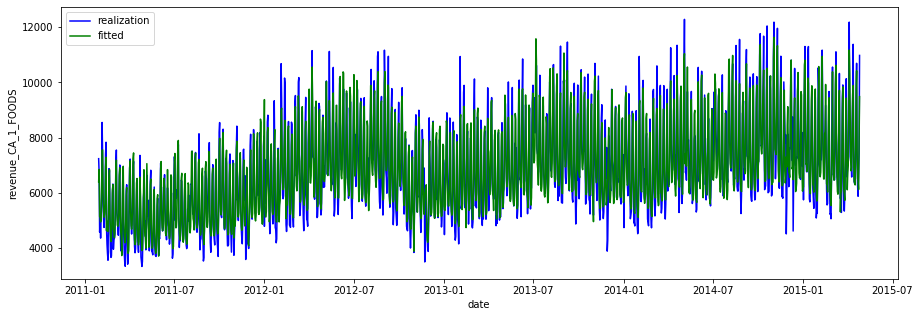

In [171]:
#Plot the fit and the training data set
plt.figure(figsize=(15, 5))
plt.plot(revenue_CA_1_FOODS_day[:-365], color = 'blue')
plt.plot(fit_values, color="green")
plt.xlabel("date")
plt.ylabel("revenue_CA_1_FOODS")
plt.legend(("realization", "fitted"),  
               loc="upper left")
plt.show()

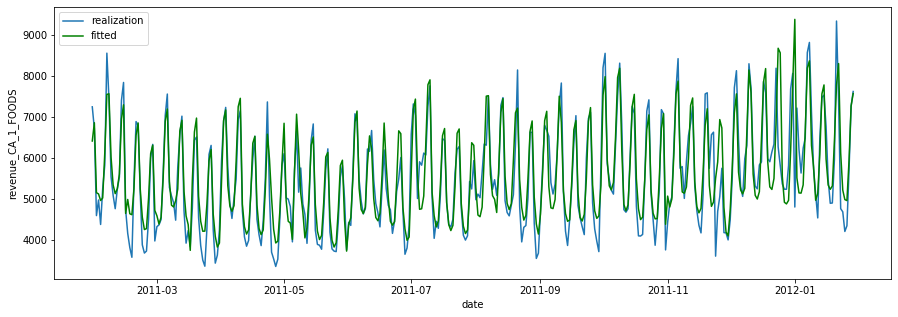

In [172]:
#Plot the fitted and training data set fpr the first year
plt.figure(figsize=(15, 5))
plt.plot(revenue_CA_1_FOODS_day[:366])
plt.plot(fit_values[:366], color="green")
plt.xlabel("date")
plt.ylabel("revenue_CA_1_FOODS")
plt.legend(("realization", "fitted"),  
               loc="upper left")
plt.show()

In [173]:
#extracting the last (most recent) values of the states for forecasting
#reversing the seasonals as the first one input into the forecast function needs to be the oldest seasonality
l_values = fit['l_list'][len(fit['l_list'])-1:]
b_values = fit['b_list'][len(fit['b_list'])-1:]
s_values = fit['s_list'][len(fit['s_list'])-7:]
yearly_values = fit['yearly_list'][len(fit['yearly_list'])-365:]

In [175]:
#creating a list of all optimal parameters for forecasting
forecast_parameters = np.concatenate([res.x[0:4],l_values,b_values,s_values,res.x[13:39]], axis=None)
forecast_parameters

array([ 1.88384700e-01,  1.00000000e-06,  1.28010711e-02,  9.99017737e-01,
        7.94280578e+03,  8.60035043e+00,  1.16715757e+00,  8.51628623e-01,
        7.37335014e-01,  7.25995391e-01,  7.19217536e-01,  8.72933901e-01,
        1.10197179e+00,  1.27233357e-01, -6.74175499e-02, -1.59706110e-01,
        2.73729943e-02,  1.42596940e-02, -4.76970371e-02,  6.27502956e-02,
       -3.44894312e-02, -2.28037597e-02,  5.57550797e-03, -1.42256749e-03,
       -7.97285872e-03,  1.82388359e-03,  7.24957229e-03,  6.90717337e-03,
        1.43811341e-02,  1.11844374e-02,  2.47296810e-03, -1.69056575e-02,
        7.30913307e-03, -9.28510565e-03, -3.24013331e-03, -8.02725990e-03,
        3.82687057e-03,  7.29014833e-03,  8.71299173e-02])

In [176]:
date = pd.to_datetime(y_predict.index)

In [177]:
#For Forecasting I require the most recent (last) state estiamtes as well as the forecasting horizon h
def forecasting(params, exog, Fourier, date, h):
    '''
    1.This function runs the optimal values threw the model to extract optimal predictions for the evaluation data.
      In essence it is identical to the model function with the exception that it does not give the time series but the 
      prediction horizon h. The computation of point forecast is done by passsing arguments to the ETS_M_Ad_M_forecast 
      function below.
      
     2.The Inputs are for an array of model parameters (param), the last state estimates from the optimal fit
       and the prediction intervall h.
       Params includes the smoothing factors and the last values for the level, trend and seasonality.
      
      Time independent smoothing parameters:
      alpha = level smoothing coefficient
      beta = trend smoothing coefficient
      gamma = seasonality smoothing coefficient
      omega = trend dampening coefficient
      
      last period T fit states computed above according to Hyndman 2008.
      l_init_HM = period T fit level
      b_init_HM = period T fit trend
      s_init7_HM ... s_init_HM = period T fit seasonal component where the number determines the lag of the dummy
      
      regression:
      exog = exogen variables (time dependent)
      reg = regression coefficient vector
    
    3.The function returns the point forecast and states for every time point in seperate lists: 
      point forecast
      l_list
      b_list
      s_list
    '''
    
    alpha = params[0] 
    beta = params[1]
    gamma = params[2]
    omega = params[3]
    l_init_HM = params[4]
    b_init_HM = params[5]
    s_init_HM = np.vstack(params[6:13])
    reg = (params[13:18])
    
     #defining the initial yearly seasonal components
    #Trick to lower the number of parameters to estimate:
    #   I dont estimate 365 dummies but rather 20 furier series weights and cumpute the dummies with them
    
    #1. compute the fourier series results from the weights times the cos(t) and sin(t) for t=0...365
    yearly_init = params[18:38] * Fourier
    #2. sum up the total yearly seasonality of each day by summing up all weighted trigonometric functional values
    yearly_init = 1 + yearly_init.sum(axis=1)
    #3. define this array of 365 dummies as an array
    yearly_init = np.vstack(yearly_init)
    #4. turn the array around as we want the most recent seasonality effect to be at the end
    yearly_init = yearly_init[::-1]
    
    #yearly smoothing parameter
    epsilon = params[38]
    results = ETS_M_Ad_M_forecast(alpha,beta,gamma,omega,
          l_init_HM,b_init_HM,s_init_HM,yearly_init,reg,h,exog,date)
   
    return results

In [178]:
def ETS_M_Ad_M_forecast(alpha,beta,gamma,omega,
          l_init_HM,b_init_HM,s_init_HM,yearly_init,reg,h,exog,date):
    '''
    1.The ETS_M_Ad_M_forecast forecast function computes the forecast h steps ahead. As the essence of prediction
      is that errors e are unavailable this simplifies the prcess greatly compared to the ETS_M_Ad_M function.
      The ETS_M_Ad_M_forecast does not calculate new state estimates or errors but merly forecasts and updates the seasonal
      states.
      
    2. Inputs are the optimal parameters for the smoothing parameters and the last state estimates of the respective fit.
    
      Time independent smoothing parameters:
      alpha = level smoothing coefficient
      beta = trend smoothing coefficient
      gamma = seasonality smoothing coefficient
      omega = trend dampening coefficient
      
      last period T fit states computed above according to Hyndman 2008.
      l_init_HM = period T fit level
      b_init_HM = period T fit trend
      s_init7_HM ... s_init_HM = period T fit seasonal component where the number determines the lag of the dummy
      
      regression:
      exog = exogen variables (time dependent)
      reg = regression coefficient vector
      
      3.The function returns the point forecast and states for every time point in seperate lists: 
      point forecast
      l_list
      b_list
      s_list
    '''
    
     #computing the number of time points as the length of the forecasting vector
    t = len(y)
    errors_list = list()
    point_forecast = list()
    l_list = list()
    b_list = list()
    s_list = list()
    yearly_list = list()
    
    
    yearly_transition_matrix, weekly_transition_matrix, yearly_update_vector, leap_year_update_vector, weekly_update_vector = seasonal_matrices()
    #Note: can create a seasonal matrix funciton which creates the transition matrix and update vector
    #depending on the length of seasonality
    #then i need to call the function twice, once for each seasonal length
    #would give the code more generalisation

    
    #Initilaisation
    l_past = l_init_HM
    b_past = b_init_HM
    
    yearly_past = yearly_init
    s_past = s_init_HM

    #computation loop:
    for i in range(1,h+1): #+1 because range(1,31): 1,..30, thus range(1,31+1): 1,...,31
        
        #compute one step ahead  forecast for timepoint t
        
        '''
        Found same error as in the model fit: the regresion part of the equation was not multiplied with the yearly seasonality
        '''
        
        mu = (l_past + omega * b_past) * s_past[0] * yearly_past[0] + np.dot(reg,exog.iloc[i-1]) * (l_past + omega * b_past) * s_past[0] * yearly_past[0]
        
        #Important Note: We need  the i-1 in: np.dot(reg,exog.iloc[i-2])
        #                Because the exog_to_test contains the first future value at zero
        
        point_forecast.append(mu)
        l_list.append(l_past)
        b_list.append(b_past)
        s_list.append(s_past)
        yearly_list.append(yearly_past[0])

        #Updating
        #no changes in level (l) and slope (b) as they remain constant without new information
        #only changes in seasonality (s) as it cycles every 7 days, the effect of each individual seasonality is not updated
        
        s_past = np.dot(weekly_transition_matrix,s_past)
        
        #yearly only moves forward one position in cylce if it isnt a leap year and the 28th febuary
        if((date.is_leap_year[i] == True) & (date.month[i] == 2) & (date.is_month_end[i+1] == True)):
            yearly_past = yearly_past
        else:
            yearly_past = np.dot(yearly_transition_matrix,yearly_past)
            
        #Tipp: no space between 'if' and conditions '(...)'

    return  {'point forecast' : point_forecast,
             'l_list' : l_list, 'b_list' : b_list, 's_list' : s_list}

In [179]:
#computing forecasts for the horizons 7,14,21,31,365 and saving the results
forecasts_7 = forecasting(forecast_parameters, exog_to_test,  Fourier, date, 7)
forecasts_14 = forecasting(forecast_parameters, exog_to_test, Fourier, date, 14)
forecasts_21 = forecasting(forecast_parameters, exog_to_test, Fourier, date, 21)
forecasts_31 = forecasting(forecast_parameters, exog_to_test, Fourier, date, 31)
forecasts_365 = forecasting(forecast_parameters, exog_to_test, Fourier, date, 360)

In [180]:
#creating a data frame with the time series as date object and index for each forecasting horizon
#Note: np.concatenate the data to form it into one array

forecasted_values_7 = pd.DataFrame({'forecast' : np.concatenate(forecasts_7['point forecast'],axis=None),
                                      'date' : pd.to_datetime(y_predict.index[:7])})
forecasted_values_7 = forecasted_values_7.set_index('date')

forecasted_values_14 = pd.DataFrame({'forecast' : np.concatenate(forecasts_14['point forecast'],axis=None),
                                      'date' : pd.to_datetime(y_predict.index[:14])})
forecasted_values_14 = forecasted_values_14.set_index('date')

forecasted_values_21 = pd.DataFrame({'forecast' : np.concatenate(forecasts_21['point forecast'],axis=None),
                                      'date' : pd.to_datetime(y_predict.index[:21])})
forecasted_values_21 = forecasted_values_21.set_index('date')

forecasted_values_31 = pd.DataFrame({'forecast' : np.concatenate(forecasts_31['point forecast'],axis=None),
                                      'date' : pd.to_datetime(y_predict.index[:31])})
forecasted_values_31 = forecasted_values_31.set_index('date')

forecasted_values_365 = pd.DataFrame({'forecast' : np.concatenate(forecasts_365['point forecast'],axis=None),
                                      'date' : pd.to_datetime(y_predict.index[:360])})
forecasted_values_365 = forecasted_values_365.set_index('date')

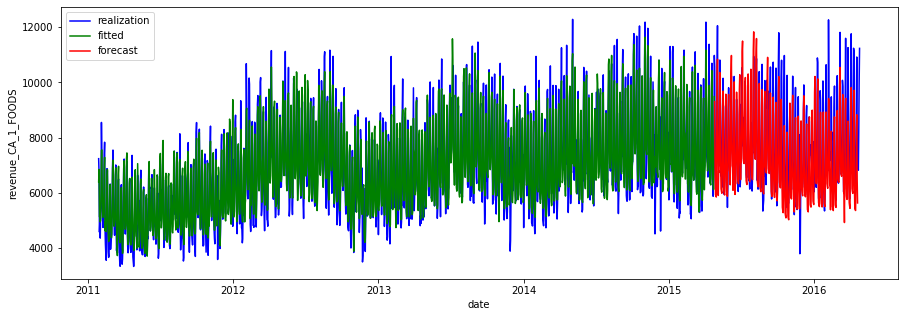

In [181]:
#Plot the results over the entire time span
plt.figure(figsize=(15, 5))
plt.plot(revenue_CA_1_FOODS_day, color = 'blue')
plt.plot(fit_values, color="green")
plt.plot(forecasted_values_365, color="red")
plt.xlabel("date")
plt.ylabel("revenue_CA_1_FOODS")
plt.legend(("realization", "fitted","forecast"),  
               loc="upper left")
plt.show()

In [182]:
#make sure the prediction data set index is a date variable for plotting
y_predict.index =pd.to_datetime(y_predict.index)

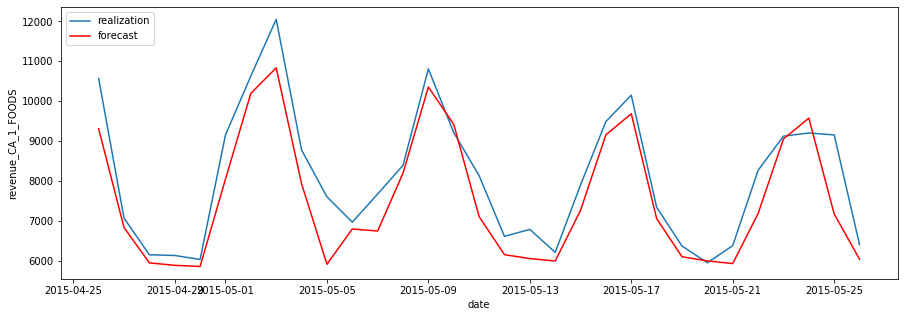

In [183]:
#Plot the first 31 days of the prediction data and their forecasts
plt.figure(figsize=(15, 5))
plt.plot(y_predict[:31])
plt.plot(forecasted_values_31, color="red")
plt.xlabel("date")
plt.ylabel("revenue_CA_1_FOODS")
plt.legend(("realization", "forecast"),  
               loc="upper left")
plt.show()

In [156]:
#defining the evaluation metrics
#from: https://mlflow.org/docs/latest/tutorials-and-examples/tutorial.html
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

In [184]:
#creating a table with the forecasting evaluation metric values for all four models
#each row contains the evaluation metrics for a model
#the loop runs threw range of 3 as we have three metrics (0,1,2)
fc_acc=pd.DataFrame(index=['rmse', 'mae', 'r2'])
fc_acc["7 Days"] = [eval_metrics(y_predict['revenue'][:7], forecasted_values_7['forecast'])[a] for a in range(0,3)]
fc_acc["14 Days"] = [eval_metrics(y_predict['revenue'][:14], forecasted_values_14['forecast'])[a] for a in range(0,3)]
fc_acc["21 Days"] = [eval_metrics(y_predict['revenue'][:21], forecasted_values_21['forecast'])[a] for a in range(0,3)]
fc_acc["31 Days"] = [eval_metrics(y_predict['revenue'][:31], forecasted_values_31['forecast'])[a] for a in range(0,3)]
fc_acc["365 Days"] = [eval_metrics(y_predict['revenue'][:360], forecasted_values_365['forecast'])[a] for a in range(0,3)]

In [185]:
fc_acc

,7 Days,14 Days,21 Days,31 Days,365 Days
rmse,675.040137,818.345618,749.143643,756.667368,946.243136
mae,523.379520,654.564114,608.392500,586.025711,716.075294
r2,0.879662,0.813821,0.811027,0.789373,0.642079


In [151]:
fc_acc.to_csv('ETS(M,Ad,M)_Exog_Yearly.csv') 